# Исследование для интернет-магазина «В один клик» 

## Описание данных

**Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.**

**Цель проекта — разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.**

**Для исследования представлено несколько таблиц:**

`market_file.csv` содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.


- `id` — номер покупателя в корпоративной базе данных.
- `Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
- `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
- `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
- `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.








`market_money.csv` содержит данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.


- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- `Выручка` — сумма выручки за период.

`market_time.csv` — таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксировано общее время.
- `минут` — значение времени, проведённого на сайте, в минутах.

`money.csv` содержит данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

- `id` — номер покупателя в корпоративной базе данных.
- `Прибыль` — значение прибыли.

**Решать задачу будем в два этапа:**
- **Разработаем модель, которая предскажет вероятность снижения покупательской активности.**
- **Выделим сегмент покупателей, проанализируем его и предложим, как увеличить его покупательскую активность с использованием данных моделирования, данных о прибыли покупателей и исходных данных (если понадобятся).**

### Загрузка данных

**Перед началом работы установим версию `scikit` 1.3.2, чтобы избежать ошибок, которые могут возникнуть из-за различий в названиях команд в разных версиях библиотеки**

In [1]:
pip install scikit-learn==1.3.2 --user

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sklearn
sklearn.__version__ # проверяем результат

'1.3.2'

**Устанавливаем другие необходимые для работы библиотеки**

In [3]:
!pip install shap
!pip install phik

**Импортируем необходимые для работы библиотеки:**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shap
import phik

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Настройки pandas
pd.set_option('display.max_columns', None)

**Обхявляем константы**

In [ ]:
RANDOM_STATE = 42 
TEST_SIZE = 0.25 

**Создадим функцию для вывода основной информации о датафрейме:**

In [5]:
def information_data(data):
    display('Первые десять строк датафрейма:')
    display(data.head(10))
    display('Общая информация о датафрейме:')
    display(data.info())
    display('Описание данных:')
    display(data.describe())
    display('Количество пропусков:')
    display(data.isna().sum())
    display('Количество дубликатов:')
    display(data.duplicated().sum())

**Открываем датасеты**

In [6]:
# Столбец `id` содержит уникальный идентификатор пользователя и не несет
# в себе полезной для анализа информации, поэтому установим его в качестве индексов

try:
    market_file = pd.read_csv('/datasets/market_file.csv', index_col='id')
    market_money = pd.read_csv('/datasets/market_money.csv', decimal = ',', index_col='id')
    market_time = pd.read_csv('/datasets/market_time.csv', decimal = ',', index_col='id')
    money = pd.read_csv('/datasets/money.csv', sep=';', decimal = ',', index_col='id')
except:
    market_file = pd.read_csv('C:\\python\\datasets\\market_file.csv', index_col='id')
    market_money = pd.read_csv('C:\\python\\datasets\\market_money.csv', decimal = ',', index_col='id')
    market_time = pd.read_csv('C:\\python\\datasets\\market_time.csv', decimal = ',', index_col='id')
    money = pd.read_csv('C:\\python\\datasets\\money.csv', sep=';', decimal = ',', index_col='id')

**Ознакомимся с данными:**

#### market_file

In [7]:
information_data(market_file)

'Первые десять строк датафрейма:'

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
id,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
215353,Снизилась,стандартт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
215354,Снизилась,стандартт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2
215355,Снизилась,стандартт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4
215356,Снизилась,стандартт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3


'Общая информация о датафрейме:'

<class 'pandas.core.frame.DataFrame'>
Index: 1300 entries, 215348 to 216647
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская активность            1300 non-null   object 
 1   Тип сервиса                          1300 non-null   object 
 2   Разрешить сообщать                   1300 non-null   object 
 3   Маркет_актив_6_мес                   1300 non-null   float64
 4   Маркет_актив_тек_мес                 1300 non-null   int64  
 5   Длительность                         1300 non-null   int64  
 6   Акционные_покупки                    1300 non-null   float64
 7   Популярная_категория                 1300 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 10  Ошибка_сервиса                       1300 non-null   int64  
 11  Страниц_за_визит            

None

'Описание данных:'

,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


'Количество пропусков:'

Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

'Количество дубликатов:'

11

В данных имеются дубликаты. Посмотрим, есть ли строки с совпадающими индексами.

In [8]:
df_with_index = market_file.reset_index()

# Найдём полные дубликаты
full_duplicates = df_with_index[df_with_index.duplicated(keep=False)]

# Вывод полных дубликатов
print(f'Количество полных дубликатов, включая индексы: {len(full_duplicates)}')

Количество полных дубликатов, включая индексы: 0


Можно двигаться дальше.

#### market_money

In [9]:
information_data(market_money)

'Первые десять строк датафрейма:'

,Период,Выручка
id,,
215348,препредыдущий_месяц,0.0
215348,текущий_месяц,3293.1
215348,предыдущий_месяц,0.0
215349,препредыдущий_месяц,4472.0
215349,текущий_месяц,4971.6
215349,предыдущий_месяц,5216.0
215350,препредыдущий_месяц,4826.0
215350,текущий_месяц,5058.4
215350,предыдущий_месяц,5457.5


'Общая информация о датафрейме:'

<class 'pandas.core.frame.DataFrame'>
Index: 3900 entries, 215348 to 216647
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Период   3900 non-null   object
 1   Выручка  3900 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


None

'Описание данных:'

,Период,Выручка
count,3900,3900
unique,3,2776
top,препредыдущий_месяц,4729.0
freq,1300,8


'Количество пропусков:'

Период     0
Выручка    0
dtype: int64

'Количество дубликатов:'

746

#### market_time

In [10]:
information_data(market_time)

'Первые десять строк датафрейма:'

,Период,минут
id,,
215348,текущий_месяц,14
215348,предыдцщий_месяц,13
215349,текущий_месяц,10
215349,предыдцщий_месяц,12
215350,текущий_месяц,13
215350,предыдцщий_месяц,8
215351,текущий_месяц,13
215351,предыдцщий_месяц,11
215352,текущий_месяц,11


'Общая информация о датафрейме:'

<class 'pandas.core.frame.DataFrame'>
Index: 2600 entries, 215348 to 216647
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Период  2600 non-null   object
 1   минут   2600 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 60.9+ KB


None

'Описание данных:'

,минут
count,2600.000000
mean,13.336154
std,4.080198
min,4.000000
25%,10.000000
50%,13.000000
75%,16.000000
max,23.000000


'Количество пропусков:'

Период    0
минут     0
dtype: int64

'Количество дубликатов:'

2561

#### money

In [11]:
information_data(money)

'Первые десять строк датафрейма:'

,Прибыль
id,
215348,0.98
215349,4.16
215350,3.13
215351,4.87
215352,4.21
215353,3.95
215354,3.62
215355,5.26
215356,4.93


'Общая информация о датафрейме:'

<class 'pandas.core.frame.DataFrame'>
Index: 1300 entries, 215348 to 216647
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Прибыль  1300 non-null   float64
dtypes: float64(1)
memory usage: 20.3 KB


None

'Описание данных:'

,Прибыль
count,1300.000000
mean,3.996631
std,1.013722
min,0.860000
25%,3.300000
50%,4.045000
75%,4.670000
max,7.430000


'Количество пропусков:'

Прибыль    0
dtype: int64

'Количество дубликатов:'

900

В данных имеется много дубликатов: это связано с тем, что при загрузке файлов в качестве индексов был установлен столбец `id`.Проверим, есть ли полные дубликаты, включая `id` покупателя:

In [12]:
datasets = [market_file, market_money, market_time, money]
dataset_names = ['market_file', 'market_money', 'market_time', 'money']

for name, data in zip(dataset_names, datasets):
    df_with_index = data.reset_index()  # сброс индекса, старый индекс станет столбцом 'index'
    full_duplicates = df_with_index[df_with_index.duplicated(keep=False)]
    print(f'Количество полных дубликатов, включая id покупателя, в наборе данных {name}: {len(full_duplicates)}')

Количество полных дубликатов, включая id покупателя, в наборе данных market_file: 0
Количество полных дубликатов, включая id покупателя, в наборе данных market_money: 0
Количество полных дубликатов, включая id покупателя, в наборе данных market_time: 0
Количество полных дубликатов, включая id покупателя, в наборе данных money: 0


### Вывод

**Содержание данных соответствует описанию. Дубликатов и пропусков ни в одной из таблиц нет. Типы данных в наборах данных в основном соответствуют содержанию, за исключением столбца `Выручка` в датафрейме `market_money`. Обработаем его на этапе предварительной обработки данных. Также в ходе предобработки устраним некоторые опечатки в таблицах и приведем к единообразному виду названия столбцов:**

1. в таблице `market_file`:
- в столбце `Тип сервиса` исправим опечатку в слове "стандарт" (сейчас "стандартт")
- в столбце `Популярная_категория` "Косметика и аксесуары" исправим на "Косметика и аксессуары", просмотрим все уникальные значения столбца, чтобы выявить другие возможные опечатки. Это важно, так как опечатки в названиях категорий могут привести к появлению неявных дубликатов, что затруднит анализ.
- приведем названия столбцов к "змеиному" регистру: `Покупательская активность`, `Тип сервиса`, `Разрешить сообщать`  

2. в таблице `market_time`:
- в столбце `Период` исправим "предыдцщий_месяц" на "предыдущий_месяц"

## Предобработка данных

Изменим тип данных в столбце `Выручка` в датафрейме `market_money`

In [13]:
market_money['Выручка'] = market_money['Выручка'].astype('float64')
market_money['Выручка'].dtype # проверяем результат

dtype('float64')

Исправим опечатки в столбцах `Тип сервиса` и `Популярная_категория`

In [14]:
market_file['Тип сервиса'] = market_file['Тип сервиса'].str.replace('стандартт', 'стандарт')
market_file['Тип сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [15]:
market_file['Популярная_категория'] = market_file['Популярная_категория'].str.replace('Косметика и аксесуары', 'Косметика и аксессуары')
market_file['Популярная_категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксессуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

Переименуем столбцы и заменим все прописные буквы на строчные в названиях столбцов

In [16]:
market_file.rename(columns={
    'Покупательская активность': 'покупательская_активность', 
    'Тип сервиса': 'тип_сервиса', 
    'Разрешить сообщать': 'разрешить_сообщать'
}, inplace=True)

market_file.columns = market_file.columns.str.lower()

In [17]:
market_time.columns

Index(['Период', 'минут'], dtype='object')

In [18]:
market_time.columns = market_time.columns.str.lower()

# Исправляем опечатку в значениях столбца
market_time['период'] = market_time['период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')

# Проверяем уникальные значения в столбце
print(market_time['период'].unique())

['текущий_месяц' 'предыдущий_месяц']


In [19]:
market_money.columns

Index(['Период', 'Выручка'], dtype='object')

In [20]:
# Изменяем название столбца на "выручка"
market_money.columns = market_money.columns.str.lower()

### Вывод

**В ходе предварительной обработки данных выволнено:**

- в столбце `выручка` в датафрейме `market_money` изменен тип данных со строкового на вещественный
- в столбце `Тип сервиса` исправили опечатку в слове "стандарт" (было "стандартт")
- в столбце `Популярная_категория` "Косметика и аксесуары" исправили на "Косметика и аксесуары", просмотрели все уникальные значения столбца, чтобы выявить другие возможные опечатки
- приведены названия столбцов к "змеиному" регистру во всех наборах данных  
- в таблице `market_time` в столбце `Период` исправили "предыдцщий_месяц" на "предыдущий_месяц"

## Исследовательский анализ данных

### Исследовательский анализ количественных столбцов

**Посмотрим основные статистические показатели числовых столбцов датафрейма** `market_file`:

In [21]:
market_file.describe()

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


**Построим гистограмму и диаграмму размаха для всех числовых столбцов таблицы `market_file`**

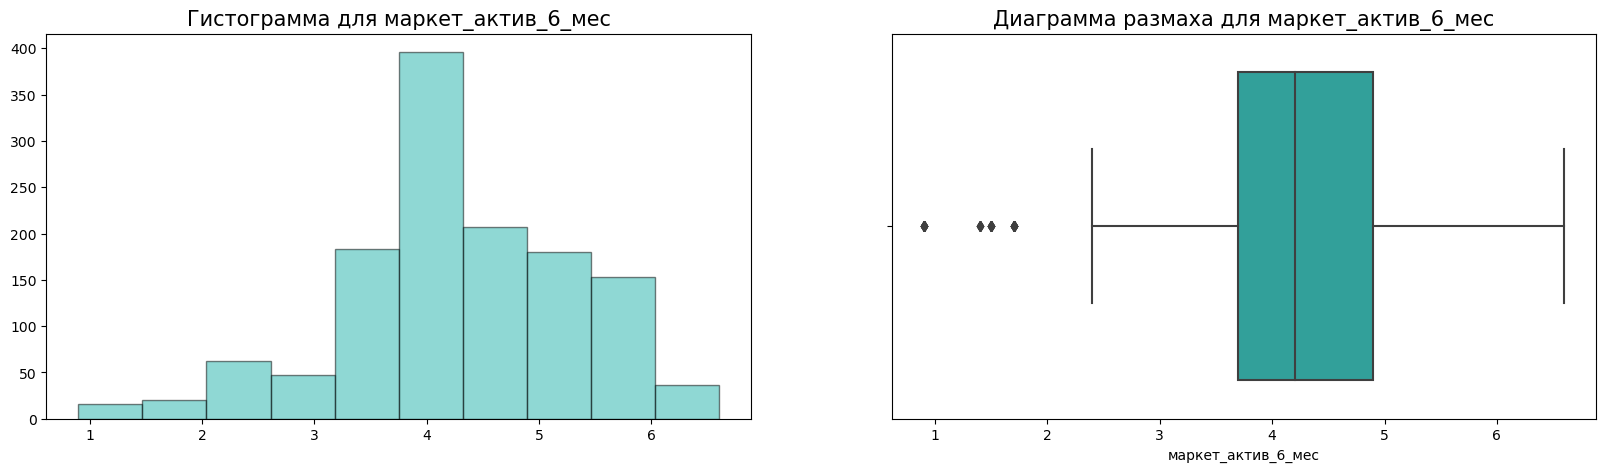

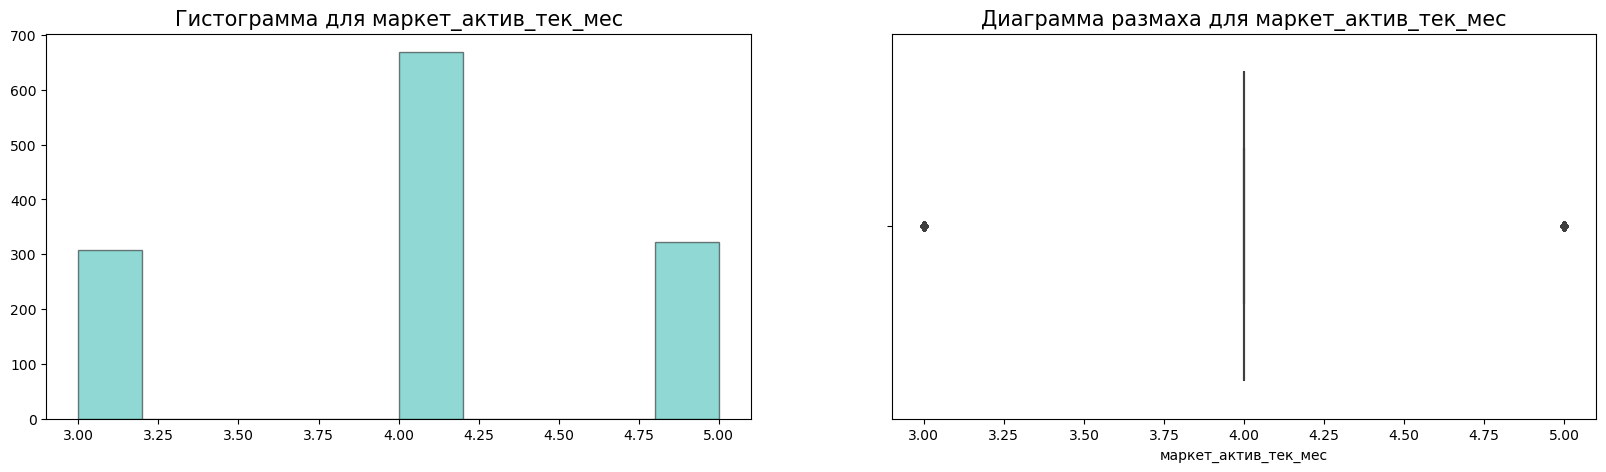

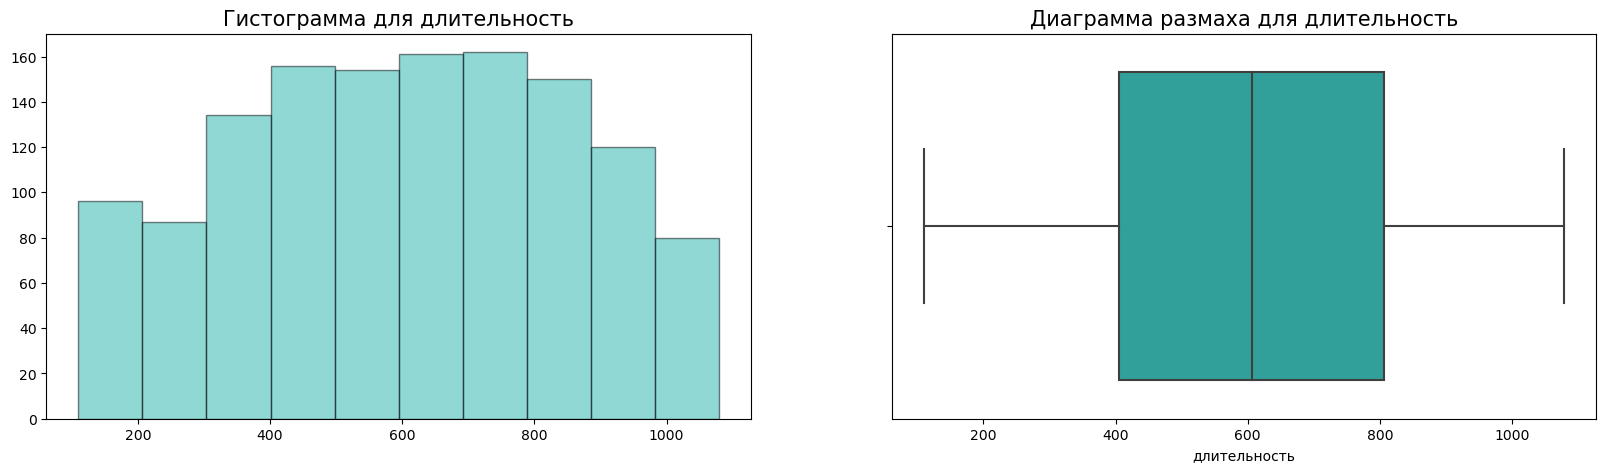

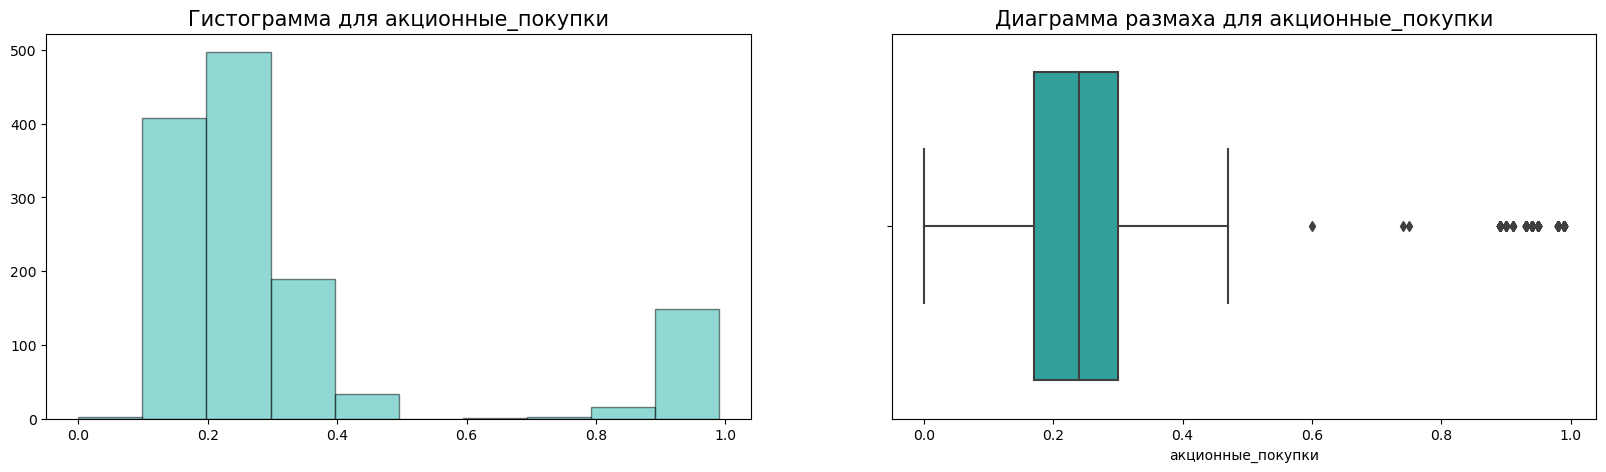

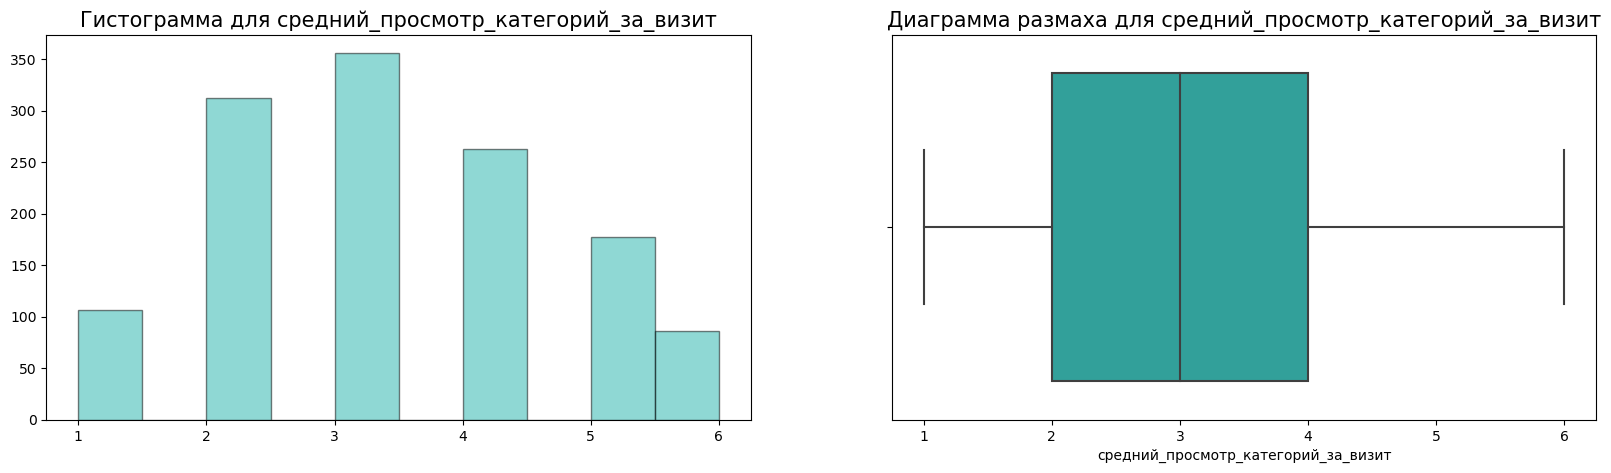

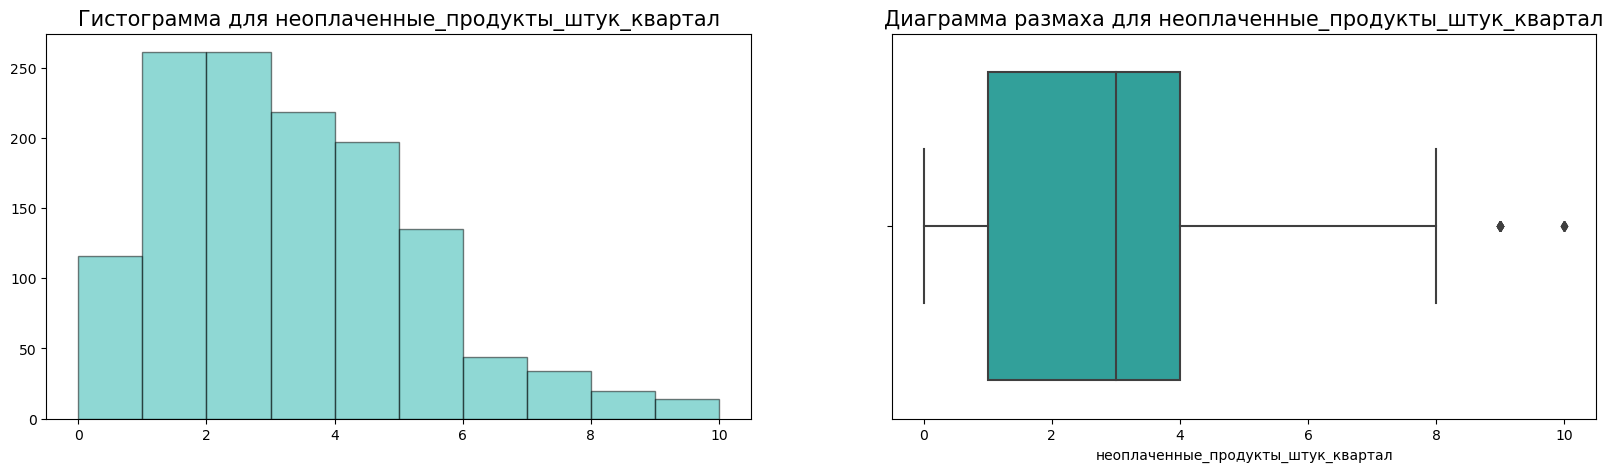

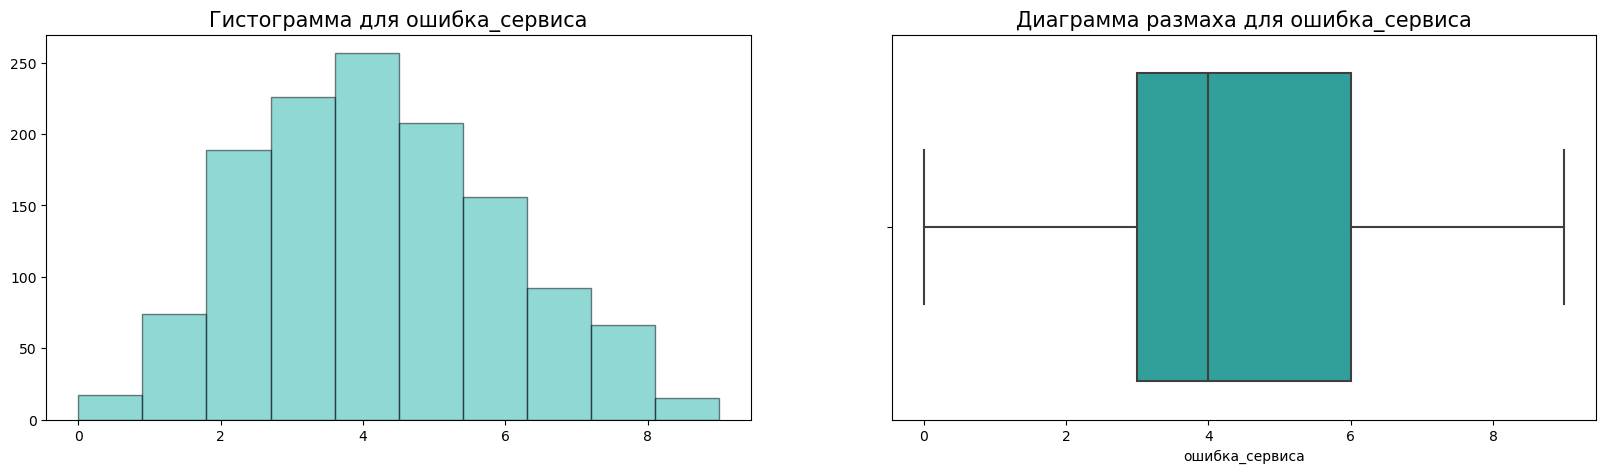

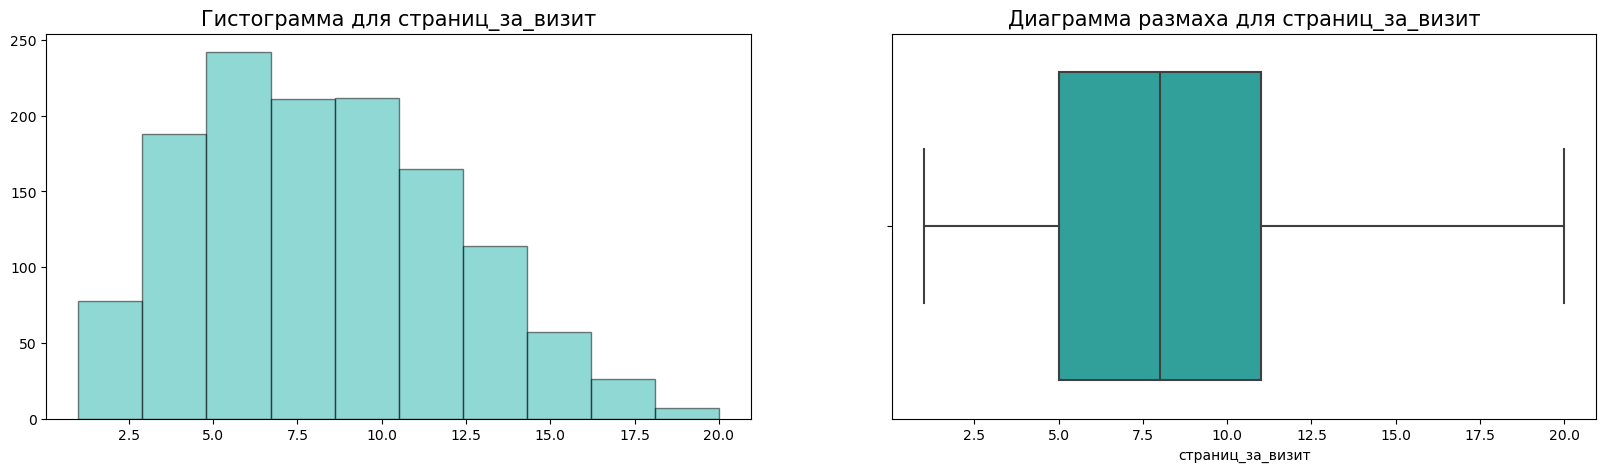

In [22]:
num_columns = [ 
    'маркет_актив_6_мес', 
    'маркет_актив_тек_мес',
    'длительность', 
    'акционные_покупки',
    'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал', 
    'ошибка_сервиса', 
    'страниц_за_визит'
]

for column in num_columns:
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    
    # Гистограмма
    axs[0].hist(market_file[column], color='lightseagreen', edgecolor='black', alpha=0.5)
    axs[0].set_title(f'Гистограмма для {column}', fontsize=15)
    
    # Диаграмма размаха
    sns.boxplot(x=market_file[column], ax=axs[1], color='lightseagreen')
    axs[1].set_title(f'Диаграмма размаха для {column}', fontsize=15)
    
    plt.show()

**Данные распределяются следующим образом:**

- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. На клиента приходится от 1 до 7 рассылок, звонков, показов рекламы и прочего. Самое часто встречающееся (медиана) значение — 4. Распределение похоже на нормальное со скосом вправо и пиком на отметке 4. Выбросами являются значения меньше 2. 

- `Маркет_актив_тек_мес` имеет три всплеска на отметках 3, 4 и 5 маркетинговых коммуникаций в текущем месяце. В текущем месяце саммое частое значение — 4 уведомления (или другой вид коммуникации).

- `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте, распределяется нормально от 0 до 1079. 

- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев, имеет два пика — на отметках 0.1-0.3 и 0.9. На диаграмме размаха видно, что значения ближе к 1 встречаются редко и отмечены как выбросы.

- `Средний_просмотр_категорий_за_визит` — в среднем категорий покупатель просмотрел за визит в течение последнего месяца 3 категории, минимальное значение — 1, максимальное — 6. 

- `Неоплаченные_продукты_штук_квартал` — число неоплаченных товаров в корзине за последние 3 месяца, распределено от 0 до 10 с пиком в районе значений 1-3. Значения больше 8 являются выбросами.

- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта, имеет минимальное значение о и максимальное значение 9. Пик приходится на отметку 4. Распределение выглядит нормально.

- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца, варьируется от 1 до 20 с пиком в районе отметки 7, распределение выглядит нормально. 


Построим график виолончели для каждого из признаков в списке features, который показывает распределение значений признака для `Покупательская активность`. Это может помочь увидеть, как распределение признака отличается между классами и может помочь понять, какие признаки могут быть важны для модели.

График виолончели показывает распределение данных и их вероятностную плотность:

- Ширина области виолончели показывает плотность точек данных. Более широкая область указывает на более высокую плотность данных.
- Белая точка в середине обозначает медиану.
- Толстая линия внутри виолончели представляет межквартильный размах (от 25-го до 75-го процентиля).
- Тонкие линии, выходящие из коробки, показывают вариацию за пределами верхнего и нижнего квартилей.

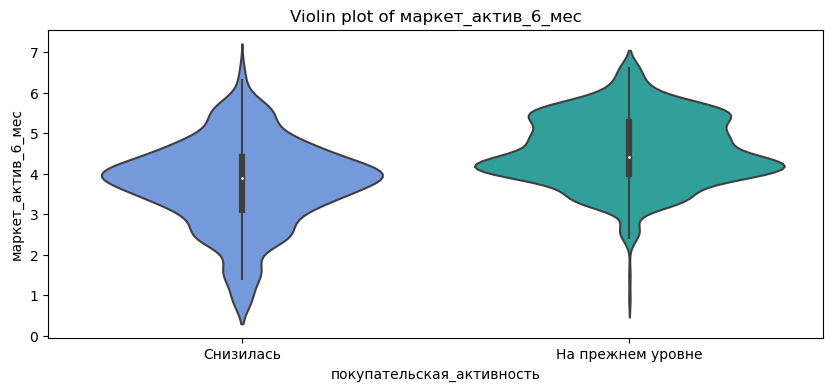

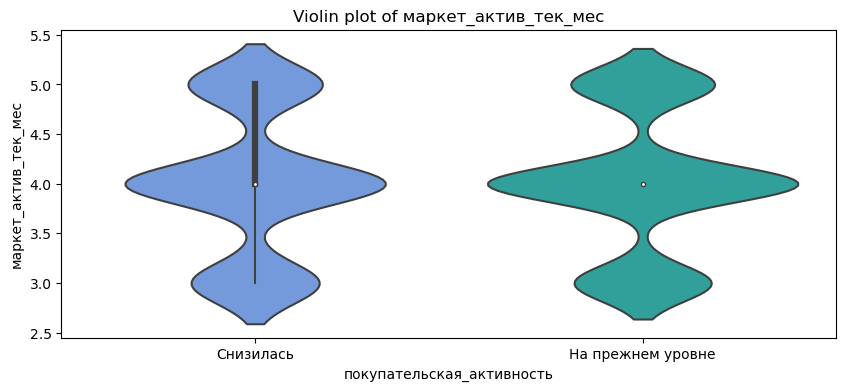

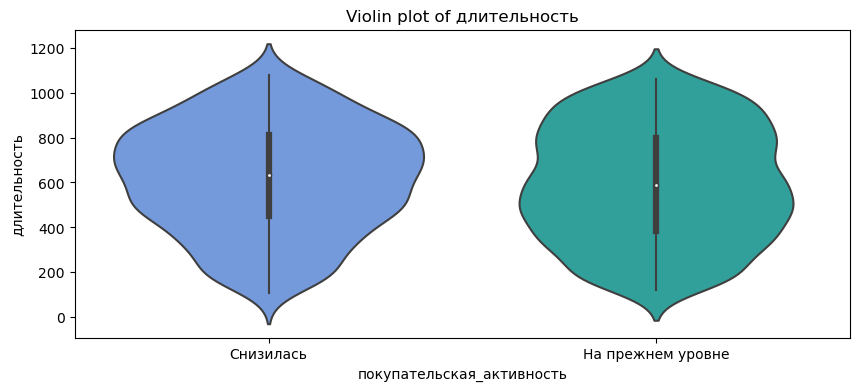

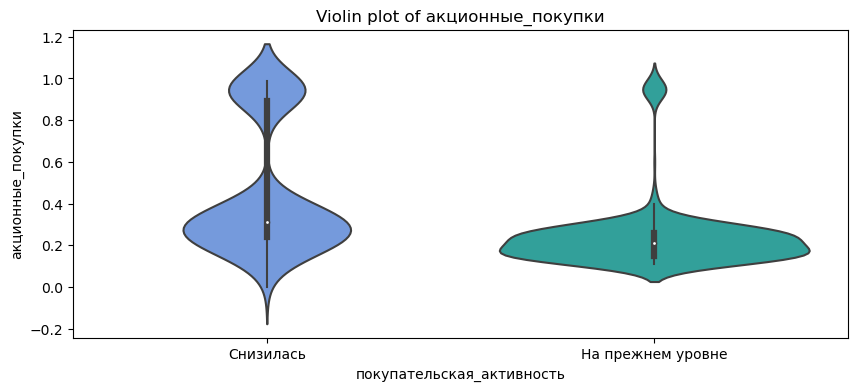

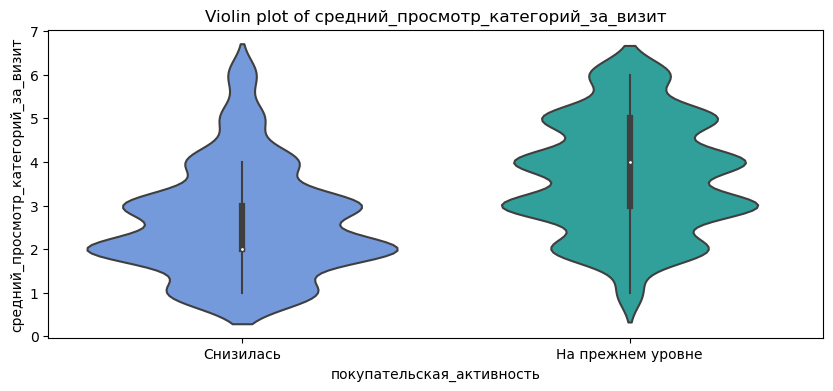

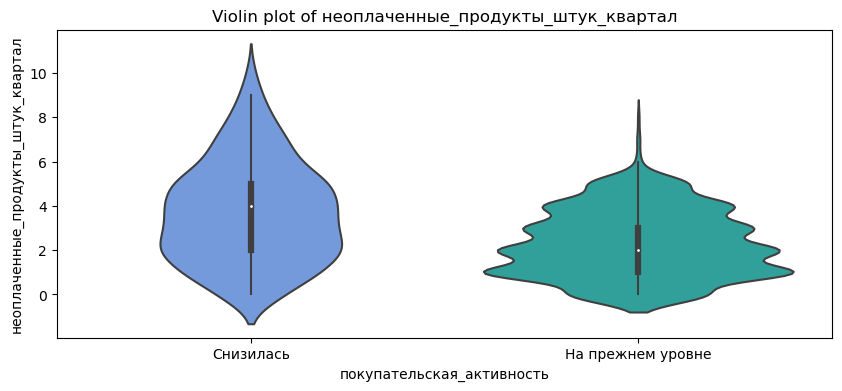

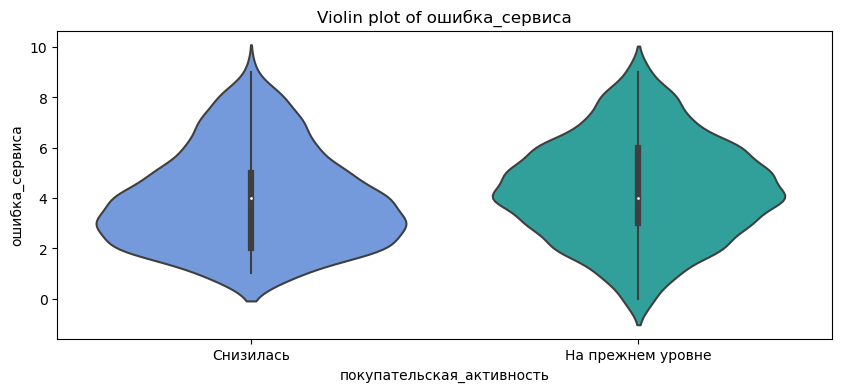

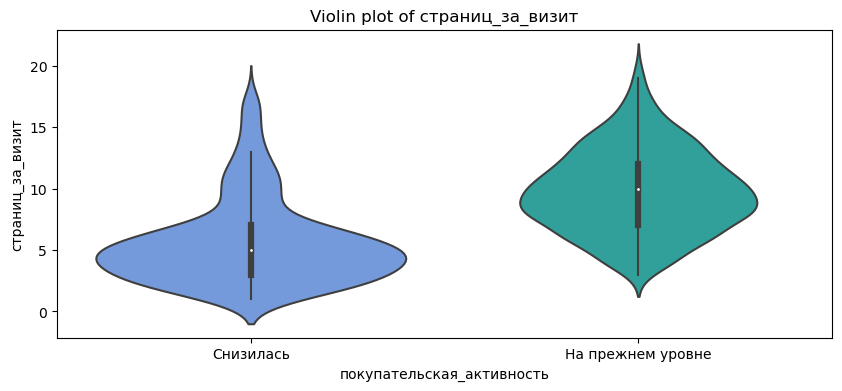

In [23]:
features = [
    'маркет_актив_6_мес', 
    'маркет_актив_тек_мес', 
    'длительность', 
    'акционные_покупки', 
    'средний_просмотр_категорий_за_визит', 
    'неоплаченные_продукты_штук_квартал', 
    'ошибка_сервиса', 
    'страниц_за_визит'
]

for feature in features:
    plt.figure(figsize=(10, 4))
    sns.violinplot(x='покупательская_активность', y=feature, data=market_file, palette=['cornflowerblue', 'lightseagreen'])
    plt.title('Violin plot of ' + feature)
    plt.xticks([0, 1], ['Снизилась', 'На прежнем уровне'])
    plt.show()

Проанализируем визуализации:
- `Маркет актив 6 мес` — для обеих групп пользователей самым распространенным значением числа взаимодействий с маркетом является 4. Медиана и значения межквартильного размаха для группы “снизилась” немного ниже. У пользователей, активность которых остается на прежнем уровне, плотность распределения на высоких показателях больше.
- `Маркет актив тек месяц` — здесь также видим, что самое распространенное значение для обеих групп 4. Более высокая плотность на этой отметке у пользователей, покупательская активность которых остается на прежнем уровне. Значительных отличий между группами не наблюдается.
- `Длительность` — “виолончели” длительности выглядят очень похоже для обеих групп, медианные значения и значения межквартильного размаха находятся примерно на одном уровне. Для группы со сниженной активностью более высокая плотность на отметке 700-800.
- `Акционные покупки` — медиана для обеих групп находится примерно на уровне 0.2-0.3. Межквартильный размах сильно различается: для группы покупателей, у которых снизилась покупательская активность, разброс большой: от 0.2 до 0.9, у группы, активность которой на прежнем уровне, межквартильный размах находится в диапазоне 0.2-0.3. Это говорит о том, что пользователи, активность которых не снизилась, редко покупают товары по акции.
- `Средний просмотр категорий за визит` — сильные отличия поведения групп. Медиана для группы “Снизилась” находится на отметке 2, в то время, как для второй группы она находится на отметке 4. Для первой группы более высокая плотность в нижней части графика, что говорит о меньшем количестве просматриваемых товаров за визит. У второй группы распределение выглядит равномерным.
- `Неоплаченные продукты штук квартал` — у группы “Снизилась” медиана находится на отметке 4 неоплаченных товара в корзине, плотность распределяется равномерно между отметками 2 и 6, также имеется большое количество точек в более высоких отметках. Для группы “На прежнем уровне” медиана находится на уровне отметки 2 и в целом большая часть графика располагается в нижней диапазоне, больше 6 неоплаченных товаров уже встречается редко.
- `Ошибка сервиса` — в целом значительных различий между графиками не наблюдается, медиана находится примерно на одной отметке, самая широкая часть “виолончели” для группы “Снизилась” находится чуть ниже отметки 3, для группы “На прежнем уровне” — ближе к 4. Это может говорить о том, что количество ошибок, с которыми сталкиваются клиенты, не влияет на их покупательскую активность.
- `Страницы за визит` — заметные различия поведения групп. Группа, у которой снизилась покупательская активность, просматривает меньше страниц за визит: медиана находится на отметке 5, самая широкая часть графика также распределена вокруг этой отметки, значения больше 8 встречаются редко. Для группы, у которой активность остается на прежнем уровне, медиана находится на отметке 10, остальные значения распределены равномерно.

**Посмотрим основные статистические показатели столбца** `Выручка` **датафрейма** `market_money`:

In [24]:
market_money.describe()

,выручка
count,3900.000000
mean,5025.696051
std,1777.704104
min,0.000000
25%,4590.150000
50%,4957.500000
75%,5363.000000
max,106862.200000


Максимальный показатель выручки составляет более 100 тысяч рублей. Посмотрим поближе на это значение:

In [25]:
market_money.loc[market_money['выручка'].idxmax()]

,период,выручка
id,,
215380,препредыдущий_месяц,5051.0
215380,предыдущий_месяц,6077.0
215380,текущий_месяц,106862.2


Пользователь с id 215380 за прошедшие два месяца тратил на маркетплейсе 5-6 тысяч рублей, а в текущем месяце потратил аж 100. Такое может случиться, однако для анализа и моделирования такое значение лучше удалить — оно может негативно влиять на работу модели при прогнозировании, кроме того данный выброс является нерепрезентативным, так как (в случае, если это значение не является следствием ошибки при сборе или выгрузке данных) отражает покупательское поведение только одного пользователя. Удалим из набора данных информацию об этом клиенте.

In [26]:
market_money.drop(215380, inplace=True)

In [27]:
market_money.describe()

,выручка
count,3897.000000
mean,4999.287760
std,706.970089
min,0.000000
25%,4590.000000
50%,4956.000000
75%,5363.000000
max,7799.400000


Значения месячной выручки от пользователей находятся в диапазоне от 0 до 7799 с средним значением 5007, медианой 4959 и стандартным отклонением 679. Для получения более точных анализов в результате исследования удалим пользователей, которые ничего не покупали хотя бы один месяц за последние три месяца.

### Отбор пользователей

Удалим из набора данных `market_money` информацию о пользователях, которые ничего не покупали хотя бы один месяц, то есть `Выручка` равна `0`. 

In [28]:
grouped = market_money.groupby([market_money.index, 'период'])['выручка'].sum()

ids_to_remove = grouped[grouped == 0].index.get_level_values(0).unique()

In [29]:
market_money = market_money[~market_money.index.isin(ids_to_remove)]

market_money.info() # проверяем результат

<class 'pandas.core.frame.DataFrame'>
Index: 3888 entries, 215349 to 216647
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   период   3888 non-null   object 
 1   выручка  3888 non-null   float64
dtypes: float64(1), object(1)
memory usage: 91.1+ KB


**Построим гистограмму выручки, полученной от пользователя за весь период взаимодействия с сайтом**

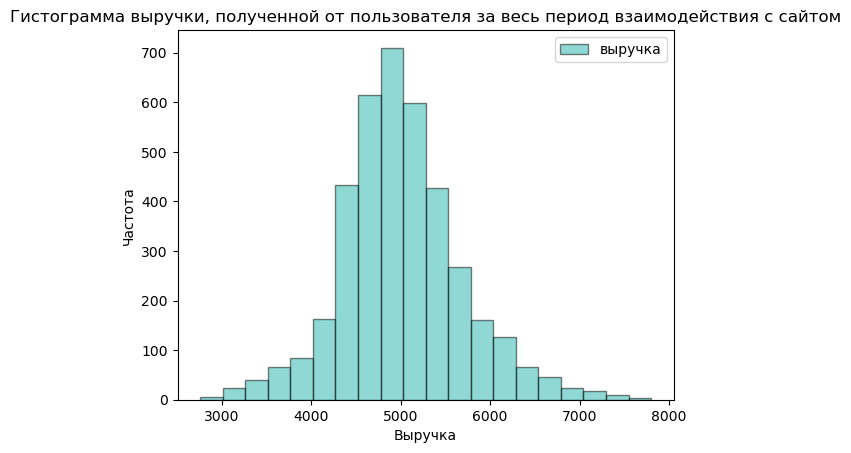

In [30]:
market_money.plot(kind='hist', bins=20, color='lightseagreen', edgecolor='black', alpha=0.5);
plt.title('Гистограмма выручки, полученной от пользователя за весь период взаимодействия с сайтом')
plt.xlabel('Выручка')
plt.ylabel('Частота');

**Выручка распределяется нормально со значениями от 2700 до 7800 и с пиком в районе значения 5000. Посмотрим, как меняется картина в разные месяцы**

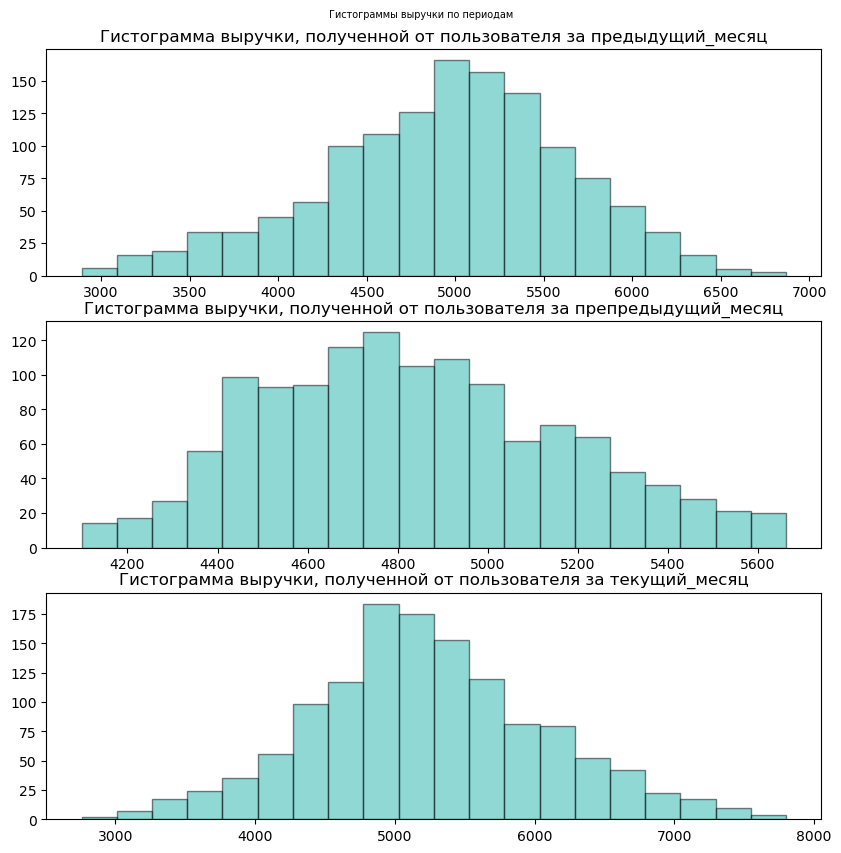

In [31]:
# Сгруппируем данные по периоду
grouped = market_money.groupby('период')
fig, axs = plt.subplots(len(grouped), figsize=(10,10))
for i, (period, data) in enumerate(grouped):
    axs[i].hist(data['выручка'], bins=20, color='lightseagreen', edgecolor='black', alpha=0.5)
    axs[i].set_title('Гистограмма выручки, полученной от пользователя за ' + period)

plt.suptitle('Гистограммы выручки по периодам', fontsize=7, y=0.92)
plt.show()

Гистограммы за три месяца показывают нормальное распределение выручки, получаемой от пользователей, в каждом периоде. В препредыдущем месяце суммы выручки варьировались от 4000 до 5700 рублей с пиком в районе 4700, по оси `у` максимальное значение находится в районе отметки 120 пользователей, в предыдущем месяце — от 3000 до 6900 и пиком в районе 5000, по оси `у` наблюдается количесто 150, в текущем месяце минимальное значение находится на отметке 2900, максимальное на 7900, пик приходится на отметку примерно 4900, по оси `у` количество пользователей находится на отметке 175. 

В целом, все три гистограммы показывают нормальное распределение, что указывает на стабильность выручки от пользователей во время этих периодов.

**Посмотрим основные статистические показатели столбца** `Минут` **датафрейма** `market_time`:

In [32]:
market_time.describe()

,минут
count,2600.000000
mean,13.336154
std,4.080198
min,4.000000
25%,10.000000
50%,13.000000
75%,16.000000
max,23.000000


Построим гистограмму для наглядности

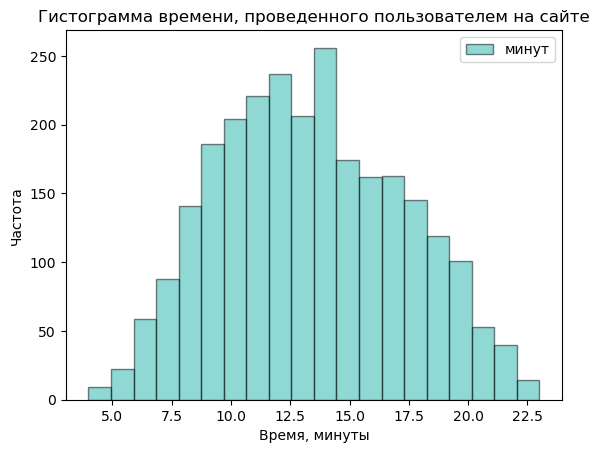

In [33]:
market_time.plot(kind='hist', bins=20, color='lightseagreen', edgecolor='black', alpha=0.5)
plt.title('Гистограмма времени, проведенного пользователем на сайте')
plt.xlabel('Время, минуты')
plt.ylabel('Частота');

Время, проведенное пользователем на сайте, распределяется нормально с минимальным значением 4 и максимальным 23. Пик приходится на значения в районе 11-15 минут. Выбросов в данных не наблюдается. 

Посмотрим отдельно по каждому периоду:

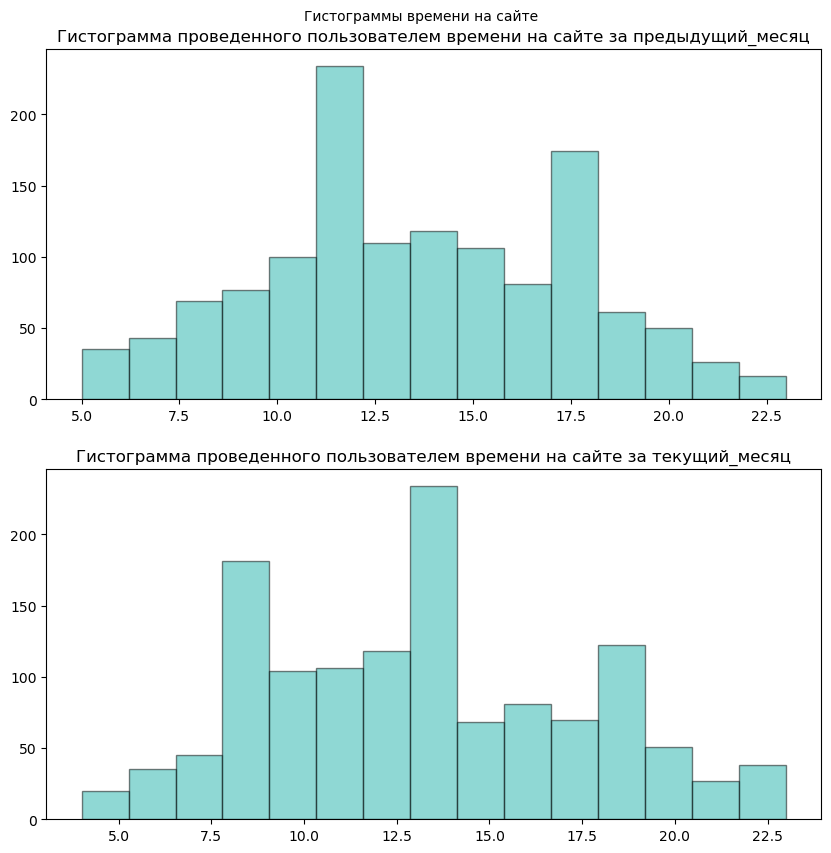

In [34]:
# Сгруппируем данные по периоду
grouped = market_time.groupby('период')
fig, axs = plt.subplots(len(grouped), figsize=(10,10))
for i, (period, data) in enumerate(grouped):
    axs[i].hist(data['минут'], bins=15, color='lightseagreen', edgecolor='black', alpha=0.5)
    axs[i].set_title('Гистограмма проведенного пользователем времени на сайте за ' + period)

plt.suptitle('Гистограммы времени на сайте', fontsize=10, y=0.92)
plt.show()

Диапазоны значений остались на том же уровне — от 5 до 22.5, а пики сместились: с 11 и 17 в предыдущем месяцу до 8 и 13 в текущем. Возможно, это связано с изменениями на сайте, сезонными факторами или другими внешними обстоятельствами.

**Проведем исследовательский анализ числовых показателей в наборе данных `money`**

In [35]:
money.describe()

,Прибыль
count,1300.000000
mean,3.996631
std,1.013722
min,0.860000
25%,3.300000
50%,4.045000
75%,4.670000
max,7.430000


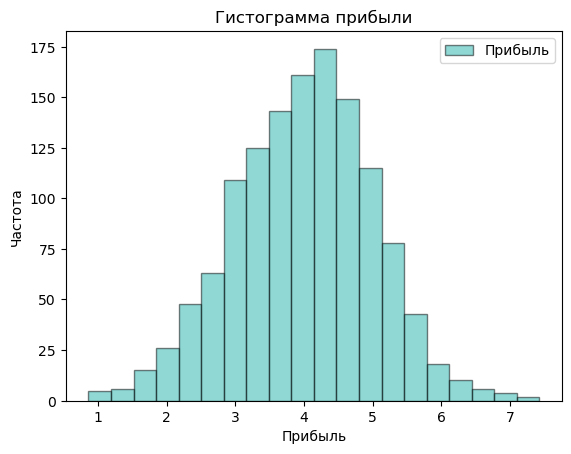

In [36]:
money.plot(kind='hist', bins=20, color='lightseagreen', edgecolor='black', alpha=0.5)
plt.title('Гистограмма прибыли')
plt.xlabel('Прибыль')
plt.ylabel('Частота');

Прибыль распределяется равномерно с минимальным значением 1 и максимальным 7, пик приходится на отметку в 4. Можно предположить, что здесь указаны данные в тысячах, заказчиком единицы измерения не указаны. Отметить какую-либо динамику здесь также не представляется возможным, так как данные представлены без разделения на периоды. Для моделирования данные из этой таблицы не понадобятся, поэтому углуляться в анализ не будем.

### Исследовательский анализ категориальных данных

Исследуем категориальные признаки набора данных `market_file`. Здесь имеется четыре категориальных признака:
- `Покупательская_активность` (целевой признак)
- `Тип_сервиса`
- `Разрешить_сообщать`
- `Популярная_категория`

Построим для категориальных признаков круговые диаграммы, воспользовавшись собственной функцией.

In [37]:
colors = ['wheat', 'lightpink', 'powderblue', 'lightcoral', 'palegreen', 'skyblue']

def plot_pie(data, column, ylbl=None, xlbl=None):
    plt.figure(figsize=(10, 7))
    data[column].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=colors)
    plt.title(f'Круговая диаграмма {column}')
    plt.xlabel(xlbl)
    plt.ylabel(ylbl)
    plt.show();

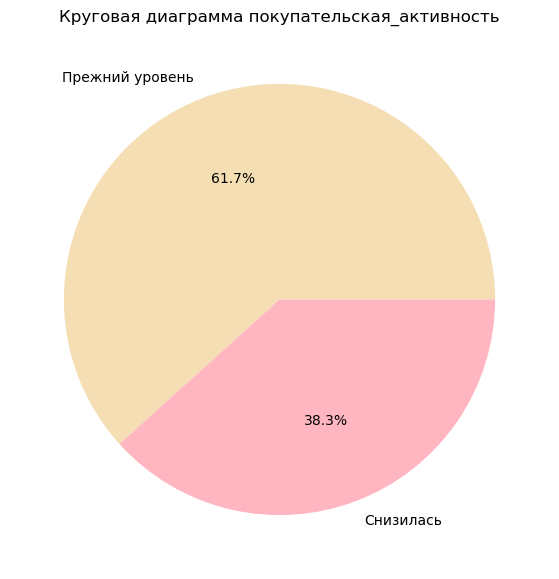

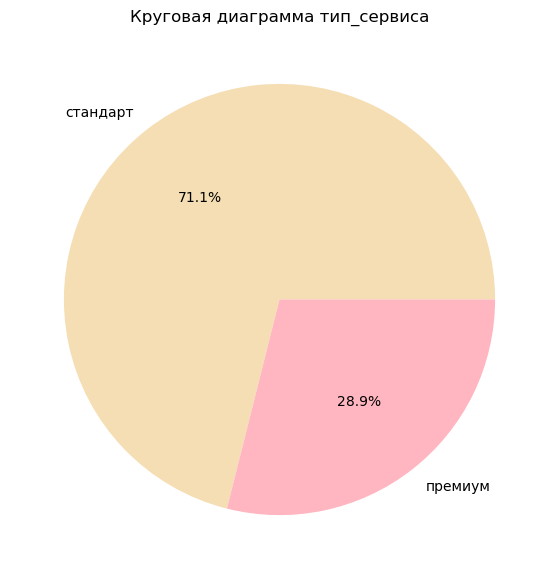

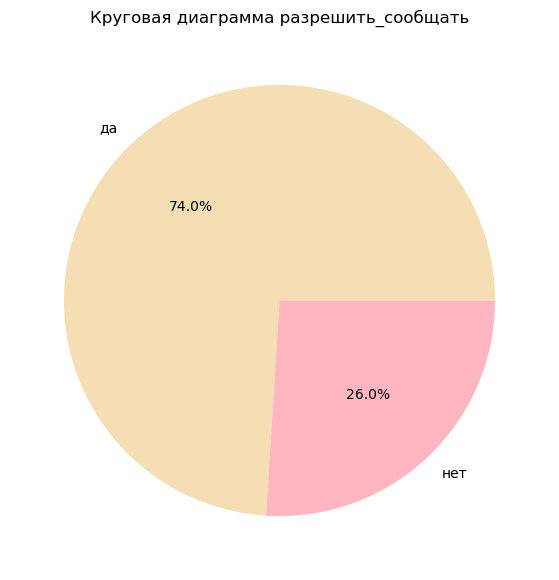

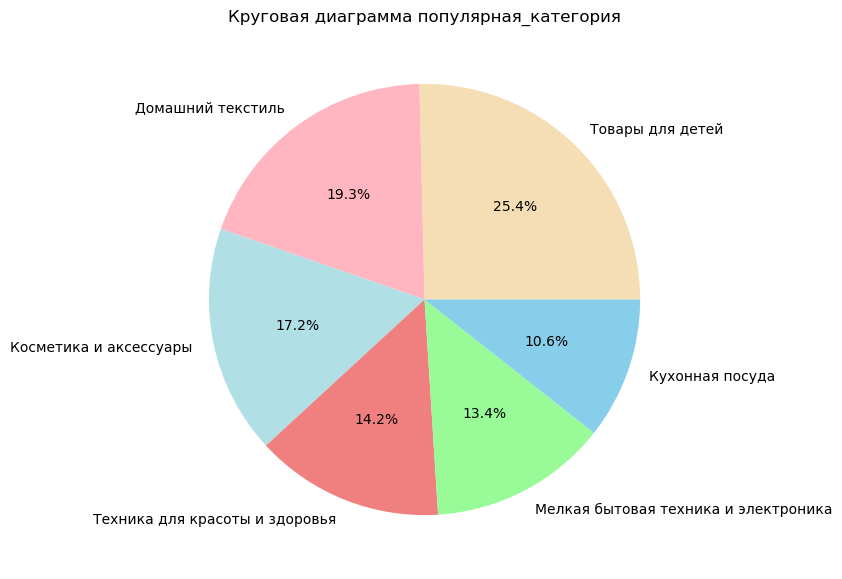

In [38]:
cat_columns = ['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
for column in cat_columns:
    plot_pie(market_file, column)

**Покупательская активность остается на прежнем уровне у 61 % покупателей, снижение отмечается у 38 % клиентов.**

**Почти три четверти клиентов пользуются сайтом без оформления премиум-подписки: 71 % пользователей "стандарт" и 29 % "премиум". Разрешение на получение дополнительных предложений дали 74 % пользователей против 26 %. Популярные категории:**

- товары для детей 25 %
- домашний текстиль 19 %
- косметика и аксессуары 17 %
- техника для красоты и здоровья 14 %
- мелкая бытовая техника и электроника 13 %
- кухонная посуда 10 %

### Вывод

**Данные распределяются следующим образом:**

- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. На клиента приходится от 1 до 7 рассылок, звонков, показов рекламы и прочего. Самое часто встречающееся значение — 4. Распределение похоже на нормальное со скосом вправо и пиком на отметке 4.
- `Маркет_актив_тек_мес` имеет три всплеска на отметках 3, 4 и 5 маркетинговых коммуникаций в текущем месяце. В текущем месяце саммое частое значение — 4 уведомления (или другой вид коммуникации).

- `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте, распределяется нормально от 0 до 1079. 

- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев, имеет два пика — на отметках 0.1-0.3 и 0.9. 

- `Средний_просмотр_категорий_за_визит` — в среднем покупатель просмотрел за визит в течение последнего месяца 3 категории, минимальное значение — 1, максимальное — 6. 

- `Неоплаченные_продукты_штук_квартал` — число неоплаченных товаров в корзине за последние 3 месяца, распределено от 0 до 10 с пиком в районе значений 1-3. 

- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта, имеет минимальное значение 0 и максимальное значение 9. Пик приходится на отметку 4. Распределение выглядит нормально.

- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца, варьируется от 1 до 20 с пиком в районе отметки 7, распределение выглядит нормально. 


**Признаки, которые не влияют на поведение пользователей:**

- `Маркет актив 6 мес` и `Маркет актив тек месяц`: Несмотря на некоторые различия в плотности распределения, общие тенденции для обеих групп пользователей схожи.
- `Длительность`: “Виолончели” длительности выглядят очень похоже для обеих групп.
- `Ошибка сервиса`: Значительных различий между графиками не наблюдается, что может говорить о том, что количество ошибок, с которыми сталкиваются клиенты, не влияет на их покупательскую активность.

**Признаки, которые имеют заметные различия:**

- `Акционные покупки`: Пользователи, чья активность не снизилась, редко покупают товары по акции, в отличие от группы, у которой активность снизилась.
- `Средний просмотр категорий за визит`: Группа, у которой снизилась покупательская активность, просматривает меньше страниц за визит.
- `Неоплаченные продукты штук квартал`: Группа, у которой снизилась покупательская активность, имеет большую медиану и равномерное распределение между отметками 2 и 6.
- `Страницы за визит`: Группа, у которой снизилась покупательская активность, просматривает меньше страниц за визит.

Явных выбросов или аномалий в данных не наблюдается.

Удалили выброс в наборе данных `market_money`. 

Гистограммы за три месяца показывают нормальное распределение выручки, получаемой от пользователей, в каждом периоде. В препредыдущем месяце суммы выручки варьировались от 4000 до 5700 рублей с пиком в районе 4700, по оси `у` максимальное значение находится в районе отметки 120 пользователей, в предыдущем месяце — от 3000 до 6900 и пиком в районе 5000, по оси `у` наблюдается количесто 150, в текущем месяце минимальное значение находится на отметке 2900, максимальное на 7900, пик приходится на отметку примерно 4900, по оси `у` количество пользователей находится на отметке 175. 

В целом, все три гистограммы показывают нормальное распределение, что указывает на стабильность выручки от пользователей во время этих периодов.

Время, проведенное пользователем на сайте, распределяется нормально с минимальным значением 4 и максимальным 23. Пик приходится на значения в районе 11-15 минут. Выбросов в данных не наблюдается. При просмотре данных за каждый месяц значения остались на том же уровне — от 5 до 22.5, а пики сместились: с 11 и 17 в предыдущем месяцу до 8 и 13 в текущем. Возможно, это связано с изменениями на сайте, сезонными факторами или другими внешними обстоятельствами.

Покупательская активность остается на прежнем уровне у 61 % покупателей, снижение отмечается у 38 % клиентов.

**Почти три четверти клиентов пользуются сайтом без оформления премиум-подписки: 71 % пользователей "стандарт" и 29 % "премиум". Разрешение на получение дополнительных предложений дали 74 % пользователей против 26 %. Популярные категории:**

- товары для детей 25 %
- домашний текстиль 19 %
- косметика и аксессуары 17 %
- техника для красоты и здоровья 14 %
- мелкая бытовая техника и электроника 13 %
- кухонная посуда 10 %

Данные о пользователях, которые ничего не покупали хотя бы один месяц, были удалены из набора данных `market_money`

## Объединение таблиц

**Чтобы объединить наборы данных, сначала в датафреймах `market_money` и `market_time` создадим отдельные столбцы для каждого периода.**

In [39]:
pivot_df_money = market_money.pivot(columns='период', values='выручка')
pivot_df_money.head()

период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
215353,4738.5,5124.0,5388.5


In [40]:
pivot_df_time = market_time.pivot(columns='период', values='минут')
pivot_df_time.head()

период,предыдущий_месяц,текущий_месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


**Объединяем всё в итоговый датасет**

In [41]:
df = market_file.merge(pivot_df_money, right_index=True, left_index=True, how='inner')
df = df.merge(pivot_df_time, right_index=True, left_index=True, how='inner')
information_data(df)

'Первые десять строк датафрейма:'

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_x,препредыдущий_месяц,текущий_месяц_x,предыдущий_месяц_y,текущий_месяц_y
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
215354,Снизилась,стандарт,да,5.1,3,431,0.23,Косметика и аксессуары,2,3,7,2,5685.0,4503.0,5869.6,11,12
215355,Снизилась,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4,3263.0,4749.0,3772.6,12,10
215356,Снизилась,стандарт,да,4.2,4,192,0.14,Косметика и аксессуары,2,2,1,3,4146.5,4433.0,4566.4,6,7
215358,Снизилась,стандарт,да,4.7,4,450,0.13,Домашний текстиль,4,2,6,4,3488.0,4727.0,4209.5,14,10


'Общая информация о датафрейме:'

<class 'pandas.core.frame.DataFrame'>
Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1296 non-null   object 
 1   тип_сервиса                          1296 non-null   object 
 2   разрешить_сообщать                   1296 non-null   object 
 3   маркет_актив_6_мес                   1296 non-null   float64
 4   маркет_актив_тек_мес                 1296 non-null   int64  
 5   длительность                         1296 non-null   int64  
 6   акционные_покупки                    1296 non-null   float64
 7   популярная_категория                 1296 non-null   object 
 8   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  ошибка_сервиса                       1296 non-null   int64  
 11  страниц_за_визит            

None

'Описание данных:'

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_x,препредыдущий_месяц,текущий_месяц_x,предыдущий_месяц_y,текущий_месяц_y
count,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000
mean,4.256404,4.009259,602.967593,0.320069,3.267747,2.841821,4.184414,8.187500,4947.468750,4836.202160,5238.096065,13.470679,13.210648
std,1.013525,0.696316,249.195823,0.249159,1.355125,1.974074,1.951719,3.978459,700.797239,333.514091,834.318717,3.937630,4.221794
min,0.900000,3.000000,121.000000,0.110000,1.000000,0.000000,0.000000,1.000000,2890.000000,4098.000000,2758.700000,5.000000,4.000000
25%,3.700000,4.000000,409.500000,0.170000,2.000000,1.000000,3.000000,5.000000,4498.125000,4584.500000,4706.050000,10.750000,10.000000
50%,4.200000,4.000000,606.500000,0.240000,3.000000,3.000000,4.000000,8.000000,5005.500000,4810.500000,5179.950000,13.000000,13.000000
75%,4.900000,4.000000,806.250000,0.300000,4.000000,4.000000,6.000000,11.000000,5405.625000,5056.000000,5759.275000,17.000000,16.000000
max,6.600000,5.000000,1079.000000,0.990000,6.000000,10.000000,9.000000,20.000000,6869.500000,5663.000000,7799.400000,23.000000,23.000000


'Количество пропусков:'

покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
предыдущий_месяц_x                     0
препредыдущий_месяц                    0
текущий_месяц_x                        0
предыдущий_месяц_y                     0
текущий_месяц_y                        0
dtype: int64

'Количество дубликатов:'

11

Пропусков в данных нет, количество строк получилось корректное — из первоначального набора удалили информацию о трех пользователях, которые ничего не покупали за интересующий период, и об одном пользователе с выручкой более ста тысяч. Для удобства переименуем столбцы.

In [42]:
df.rename(columns={
    'предыдущий_месяц_x' : 'выручка_предыдущий_месяц',
    'препредыдущий_месяц' : 'выручка_препредыдущий_месяц',
    'текущий_месяц_x' : 'выручка_текущий_месяц',
    'предыдущий_месяц_y' : 'время_предыдущий_месяц',
    'текущий_месяц_y' : 'время_текущий_месяц',
}, inplace=True)

In [43]:
information_data(df)

'Первые десять строк датафрейма:'

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
215354,Снизилась,стандарт,да,5.1,3,431,0.23,Косметика и аксессуары,2,3,7,2,5685.0,4503.0,5869.6,11,12
215355,Снизилась,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4,3263.0,4749.0,3772.6,12,10
215356,Снизилась,стандарт,да,4.2,4,192,0.14,Косметика и аксессуары,2,2,1,3,4146.5,4433.0,4566.4,6,7
215358,Снизилась,стандарт,да,4.7,4,450,0.13,Домашний текстиль,4,2,6,4,3488.0,4727.0,4209.5,14,10


'Общая информация о датафрейме:'

<class 'pandas.core.frame.DataFrame'>
Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1296 non-null   object 
 1   тип_сервиса                          1296 non-null   object 
 2   разрешить_сообщать                   1296 non-null   object 
 3   маркет_актив_6_мес                   1296 non-null   float64
 4   маркет_актив_тек_мес                 1296 non-null   int64  
 5   длительность                         1296 non-null   int64  
 6   акционные_покупки                    1296 non-null   float64
 7   популярная_категория                 1296 non-null   object 
 8   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  ошибка_сервиса                       1296 non-null   int64  
 11  страниц_за_визит            

None

'Описание данных:'

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц
count,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000
mean,4.256404,4.009259,602.967593,0.320069,3.267747,2.841821,4.184414,8.187500,4947.468750,4836.202160,5238.096065,13.470679,13.210648
std,1.013525,0.696316,249.195823,0.249159,1.355125,1.974074,1.951719,3.978459,700.797239,333.514091,834.318717,3.937630,4.221794
min,0.900000,3.000000,121.000000,0.110000,1.000000,0.000000,0.000000,1.000000,2890.000000,4098.000000,2758.700000,5.000000,4.000000
25%,3.700000,4.000000,409.500000,0.170000,2.000000,1.000000,3.000000,5.000000,4498.125000,4584.500000,4706.050000,10.750000,10.000000
50%,4.200000,4.000000,606.500000,0.240000,3.000000,3.000000,4.000000,8.000000,5005.500000,4810.500000,5179.950000,13.000000,13.000000
75%,4.900000,4.000000,806.250000,0.300000,4.000000,4.000000,6.000000,11.000000,5405.625000,5056.000000,5759.275000,17.000000,16.000000
max,6.600000,5.000000,1079.000000,0.990000,6.000000,10.000000,9.000000,20.000000,6869.500000,5663.000000,7799.400000,23.000000,23.000000


'Количество пропусков:'

покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
выручка_предыдущий_месяц               0
выручка_препредыдущий_месяц            0
выручка_текущий_месяц                  0
время_предыдущий_месяц                 0
время_текущий_месяц                    0
dtype: int64

'Количество дубликатов:'

11

## Корреляционный анализ

**Для проведения корреляционного анализа используем библиотеку `phik`, которая сама кодирует категориальные признаки, поэтому методу можно просто передать набор данных.**

In [44]:
df['время_текущий_месяц'].unique()

array([10, 13, 11, 12,  7,  6,  5,  9, 14,  8, 15,  4, 16, 18, 19, 22, 20,
       17, 21, 23], dtype=int64)

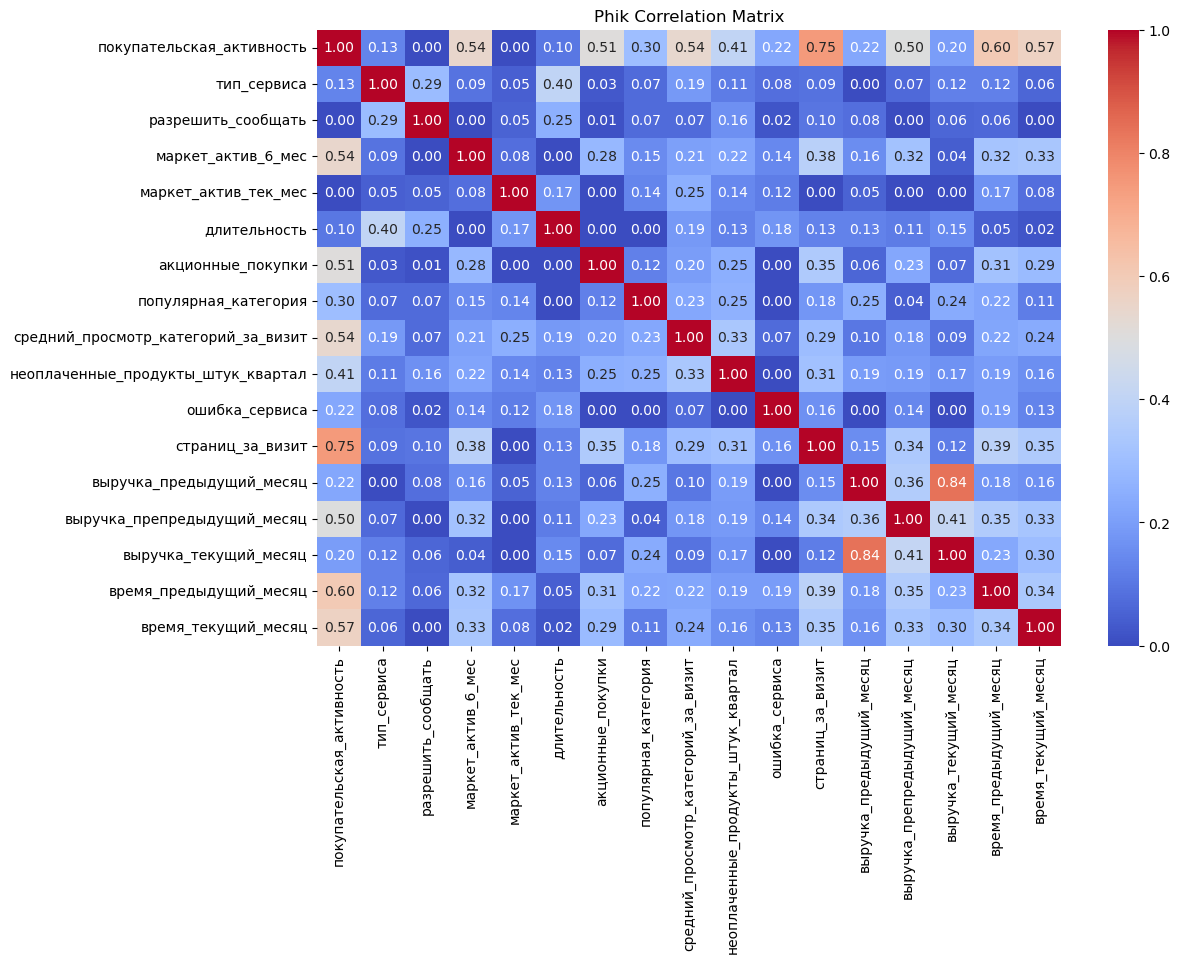

In [45]:
# Вычисление матрицы корреляции phik
phik_matrix = df.phik_matrix(interval_cols=[
    'маркет_актив_6_мес',  
    'длительность', 
    'акционные_покупки', 
    'выручка_предыдущий_месяц', 
    'выручка_препредыдущий_месяц', 
    'выручка_текущий_месяц'
])

# Визуализация матрицы корреляции с помощью тепловой карты
plt.figure(figsize=(12, 8))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Phik Correlation Matrix')
plt.show();

**Между признаками `Выручка_предыдущий_месяц` и `Выручка_текущий_месяц` наблюдается высокая корреляция `0.84`, что может привести к проблемам при обучении моделей машинного обучения: логистической регрессии, дерева решений и метода опорных векторов (посдледние два менее чувствительны к мультиколлинеарности). Учтем это при использовании пайплайнов.**

### Вывод

На данном этапе был проведен корреляционный анализ данных. Целевой признак имеет высокую корреляцию с такими признаками:
- Страниц_за_визит
- Время_предыдущий_месяц

и среднюю со следующими признаками:
- Маркет_актив_6_мес
- Акционные_покупки 
- Средний_просмотр_категорий_за_визит
- Неоплаченные_продукты_штук_квартал
- Время_текущий_месяц

Между признаками `Выручка_предыдущий_месяц` и `Выручка_текущий_месяц` была обнаружена высокая корреляция `0.84`. Учтем это при использовании пайплайнов. 

## Использование пайплайнов

Три признака: Тип_сервиса, Разрешить_сообщать, Популярная_категория — будем кодировать с помощью OneHotEncoder.

Целевой признак — Покупательская_активность. 

Количественные признаки Маркет_актив_6_мес, Маркет_актив_тек_мес, Длительность, Акционные_покупки, Средний_просмотр_категорий_за_визит, Неоплаченные_продукты_штук_квартал, Ошибка_сервиса, Страниц_за_визит,  Выручка_предыдущий_месяц, Выручка_текущий_месяц, Выручка_препредыдущий_месяц, Время_предыдущий_месяц, Время_текущий_месяц нужно масштабировать.

Будем использовать метрику roc_auc, так как она нечувствительна к дисбалансу классов (в наших же данных явно имеется дисбаланс — целевой признак распределяется на 62 % и 38 % покупателей). Метрика хорошо подходит для ситуаций, когда необходимо оценить качество работы модели вне зависимости от выбранного порога вероятности.

In [46]:
# Подготовка данных
le = LabelEncoder() 
df['покупательская_активность'] = le.fit_transform(df['покупательская_активность']) 

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['покупательская_активность'], axis=1), 
    df['покупательская_активность'], 
    test_size=TEST_SIZE,  
    random_state=RANDOM_STATE, 
    stratify=df['покупательская_активность'] # Задаем стратификацию по целевой переменной для сохранения баланса классов
)

# Задаем столбцы для различных типов преобразований
ohe_columns = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
num_columns = [ 
    'маркет_актив_6_мес', 
    'маркет_актив_тек_мес',
    'длительность', 
    'акционные_покупки',
    'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал', 
    'ошибка_сервиса', 
    'страниц_за_визит',
    'выручка_предыдущий_месяц', 
    'выручка_препредыдущий_месяц', 
    'выручка_текущий_месяц',
    'время_предыдущий_месяц',
    'время_текущий_месяц'
]

# Создаем пайплайны для каждого типа преобразования
ohe_pipe = Pipeline([ 
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')), 
    ('ohe', OneHotEncoder(drop='first')) 
])

# Создаем ColumnTransformer для применения различных преобразований к различным столбцам
data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns), 
    ('num', 'passthrough', num_columns) 
], remainder='passthrough') 

# Создаем итоговый пайплайн
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor), 
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE)) 
])

# Задаем сетку параметров для поиска
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)], 
        'models__max_depth': range(2, 5), 
        'models__max_features': range(2, 5), 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5), 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')], 
        'models__C': range(1, 5), # Параметры модели
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)], 
        'models__kernel': ['linear', 'sigmoid', 'poly', 'rbf'], 
        'models__degree': range(2, 6), 
        'models__C': np.linspace(0.1, 1, 10), 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

# Создаем экземпляр RandomizedSearchCV для поиска лучших параметров
randomized_search = RandomizedSearchCV(
    pipe_final,  
    param_grid,  
    cv=5, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE, 
    n_jobs=-1
)
randomized_search.fit(X_train, y_train) 

# Выводим лучшую модель и её параметры
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Метрика лучшей модели на валидационной выборке:', randomized_search.best_score_)

# Оцениваем модель на тестовом наборе
y_test_pred_proba = randomized_search.predict_proba(X_test)[:, 1] 
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred_proba)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['тип_сервиса',
                                                   'разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('num', StandardScaler(),
                                                  ['маркет_актив_6_мес',
                                                   'маркет_актив_тек_мес',
         

In [47]:
classes = le.classes_
le.classes_
mapping = dict(zip(classes, le.transform(classes)))
print(f'Целевой признак "Покупательская активность" закодирован следующим образом: {mapping}')

Целевой признак "Покупательская активность" закодирован следующим образом: {'Прежний уровень': 0, 'Снизилась': 1}


Преобразуем результаты поиска гиперпараметров в DataFrame для более удобного анализа. Выведем на экран столбцы, которые представляют важную информацию о производительности каждой комбинации параметров:

- `std_test_score`: стандартное отклонение тестового счета, показывающее вариативность результатов модели;
- `rank_test_score`: ранг каждой комбинации параметров, основанный на их тестовом счете, помогающий быстро определить, какие параметры дали наилучший результат;
- `param_models`: параметры модели для каждой комбинации параметров;
- `mean_test_score`: средний тестовый счет для каждой комбинации параметров, ключевая метрика для сравнения эффективности различных моделей;
- `params`: параметры, использованные для каждой комбинации параметров.

Отсортируем датафрейм по `rank_test_score`, чтобы модели с наилучшими результатами отображались первыми. Это поможет увидеть, какие параметры работают лучше всего для нашей модели.

In [48]:
# преобразовываем результаты в датафрейм и выводим результаты на экран
pd.DataFrame(randomized_search.cv_results_)[
    ['std_test_score', 'rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')

,std_test_score,rank_test_score,param_models,mean_test_score,params
3,0.010199,1,"SVC(probability=True, random_state=42)",0.909742,"{'preprocessor__num': StandardScaler(), 'model..."
7,0.016702,2,"SVC(probability=True, random_state=42)",0.894153,"{'preprocessor__num': MinMaxScaler(), 'models_..."
0,0.016463,3,"SVC(probability=True, random_state=42)",0.887224,"{'preprocessor__num': 'passthrough', 'models__..."
4,0.014680,4,"SVC(probability=True, random_state=42)",0.886356,"{'preprocessor__num': MinMaxScaler(), 'models_..."
1,0.033387,5,"SVC(probability=True, random_state=42)",0.742173,"{'preprocessor__num': 'passthrough', 'models__..."
6,0.033488,6,"SVC(probability=True, random_state=42)",0.742150,"{'preprocessor__num': 'passthrough', 'models__..."
9,0.033451,7,"SVC(probability=True, random_state=42)",0.736366,"{'preprocessor__num': 'passthrough', 'models__..."
2,0.037946,8,DecisionTreeClassifier(random_state=42),0.717946,"{'preprocessor__num': StandardScaler(), 'model..."
5,0.046499,9,"SVC(probability=True, random_state=42)",0.613414,"{'preprocessor__num': MinMaxScaler(), 'models_..."
8,0.058635,10,"SVC(probability=True, random_state=42)",0.594979,"{'preprocessor__num': 'passthrough', 'models__..."


### Вывод

Лучшей моделью оказалась модель опорных векторов (SVC) со следующими параметрами:

`C=0.8`: Это параметр регуляризации, который контролирует баланс между достижением максимального отступа и минимизацией ошибки классификации.

`degree=4`: Этот параметр используется только для полиномиального ядра и определяет степень полинома.

`probability=True`: Метод predict_proba возвращает вероятности классов для каждого образца, и он доступен только если при создании модели SVC параметр probability был установлен в True.

`random_state=42`: Это параметр, который контролирует случайность модели для воспроизводимости результатов.

**Подготовка данных**: Данные были подготовлены с использованием ColumnTransformer, который применяет разные преобразования к разным столбцам входных данных. В частности, использовали OneHotEncoder для категориальных признаков (Тип_сервиса, Разрешить_сообщать, Популярная_категория), и StandardScaler для количественных признаков (например, Маркет_актив_6_мес, Маркет_актив_тек_мес, и т.д.).

**Метрика лучшей модели на тренировочной выборке**: Значение метрики ROC-AUC для лучшей модели на тренировочной выборке составило примерно 0.91. Это означает, что модель имеет хорошую способность различать положительные и отрицательные классы.

**Метрика ROC-AUC на тестовой выборке**: Значение метрики ROC-AUC для лучшей модели на тестовой выборке составило примерно 0.91. Это означает, что модель также хорошо работает на новых, ранее не виденных данных.

## Анализ важности признаков

###  Оценим важность признаков для лучшей модели и построим график важности с помощью метода SHAP. 

PermutationExplainer explainer: 973it [08:29,  1.88it/s]                         


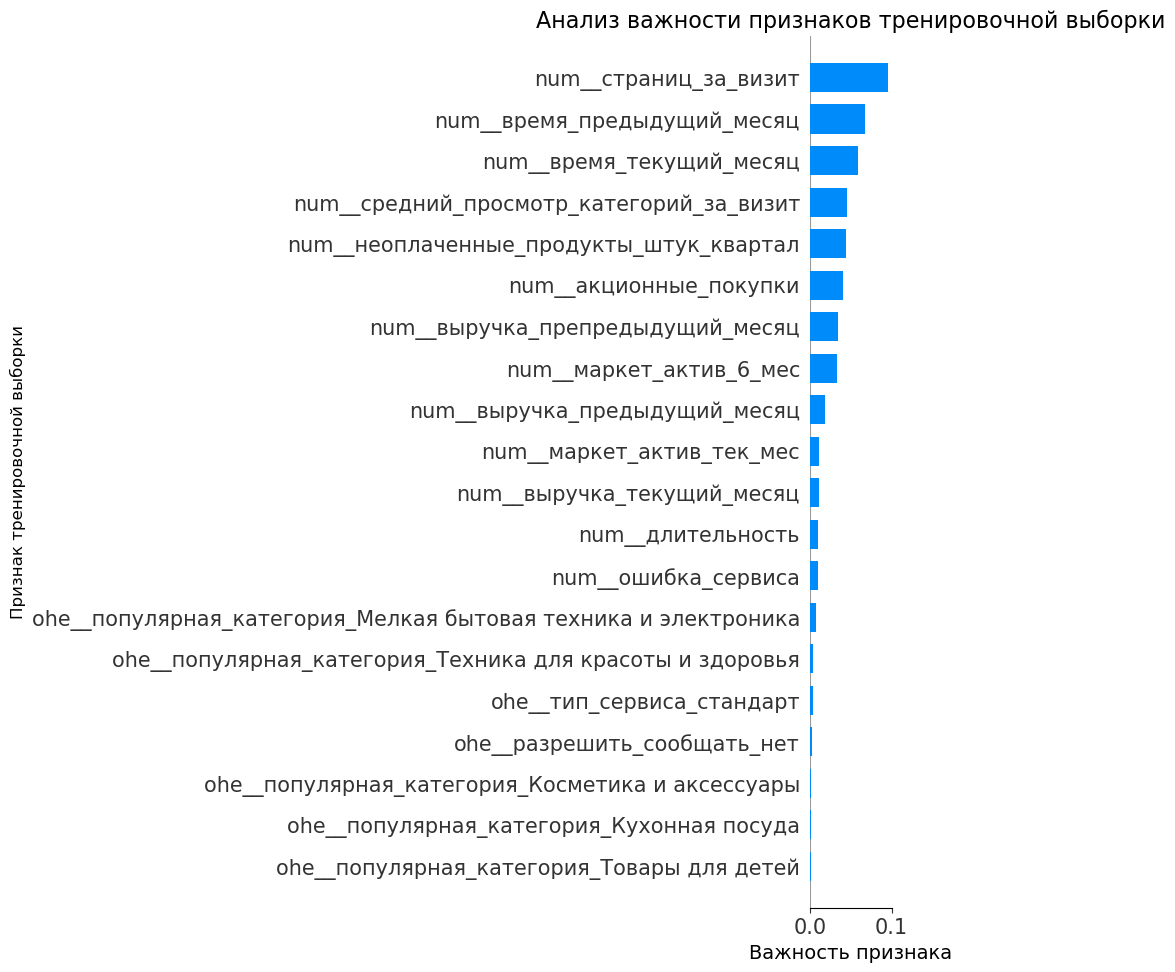

In [57]:
best_model = randomized_search.best_estimator_

X_encoded = best_model['preprocessor'].transform(X_train)
explainer = shap.PermutationExplainer(lambda X: best_model['models'].predict_proba(X)[:, 1], X_encoded)
labels = best_model['preprocessor'].get_feature_names_out()
X_encoded_df = pd.DataFrame(X_encoded, columns=labels)
fig, ax = plt.subplots()
shap.summary_plot(explainer.shap_values(X_encoded_df), plot_type='bar', feature_names=labels, show=False)
ax.tick_params(labelsize=14)
ax.set_xlabel('Важность признака', fontsize=14)
ax.set_title('Анализ важности признаков тренировочной выборки', fontsize=16)
cb_ax = fig.axes[0] 
cb_ax.tick_params(labelsize=15)
cb_ax.set_ylabel('Признак тренировочной выборки', fontsize=12)

plt.show()

### Сделаем выводы о значимости признаков:

Анализ значимости признаков

- `Страниц_за_визит` наиболее значимый признак.
Количество страниц, посещённых пользователем за визит, сильно влияет на предсказания модели. Это может указывать на то, что пользователи, которые просматривают больше страниц, демонстрируют определённое поведение, связанное с активностью или заинтересованностью в сервисе.

- `Время_предыдущий_месяц` второй по значимости признак.
Время, проведённое пользователем на сайте в предыдущем месяце, важно для модели. Это может свидетельствовать о том, что пользователи с высокой активностью в предыдущем месяце продолжают демонстрировать активность.

- `Время_текущий_месяц`: третий по значимости признак.
Текущее время на сайте также важно, что подтверждает значимость текущей активности пользователя.

- `Средний_просмотр_категорий_за_визит`:
Количество категорий, просматриваемых за визит, тоже важно. Это может указывать на разнообразие интересов пользователя. 

- `Акционные_покупки`:
Число покупок по акции влияет на предсказания модели. Это может быть связано с тем, что акционные покупки привлекают активных и заинтересованных пользователей.

- `Неоплаченные_продукты_штук_квартал`:
Количество неоплаченных продуктов за квартал может указывать на частоту совершения покупок и потенциал для будущих продаж.

- `Маркет_актив_6_мес`:
Маркетинговая активность за последние 6 месяцев также значима. Это может указывать на эффективность маркетинговых кампаний в привлечении пользователей.

- `Выручка_препредыдущий_месяц`:
Выручка за предпредыдущий месяц является значимым признаком. Это может свидетельствовать о стабильности покупательской активности.

- `Популярная_категория`:
Категория популярности также важна. Это может указывать на предпочтения пользователей к определённым категориям товаров или услуг.

- `Ошибка_сервиса`:
Наличие ошибок сервиса влияет на предсказания модели. Это может быть связано с неудовлетворённостью пользователей или с проблемами, влияющими на пользовательский опыт.

- `Маркет_актив_тек_мес`:
Маркетинговая активность в текущем месяце также имеет значимость, хотя и меньшую. Это может указывать на краткосрочные эффекты маркетинговых усилий.

- `Длительность`:
Время с регистрации пользователя на сайте также влияет на предсказания, но не так значительно, как другие признаки.

- `Выручка_текущий_месяц` и `Выручка_предыдущий месяц`:
Выручка за два месяца (текущий и предыдущий) влияет на предсказания модели, но имеет относительно низкую значимость.

- `Тип_сервиса_стандарт` и `ohe__Разрешить_сообщать_нет`:
Эти признаки имеют наименьшую значимость. Это может указывать на то, что тип сервиса и разрешение на уведомления не сильно влияют на поведение пользователей в данной модели.

Основные выводы:

Признаки, связанные с активностью пользователя на сайте (количество страниц за визит, время на сайте), являются наиболее значимыми для модели.
Маркетинговая активность и количество акционных покупок также оказывают существенное влияние на предсказания модели.
Признаки, такие как тип сервиса и разрешение на уведомления, имеют низкую значимость.
Рекомендации:

Фокус на улучшение пользовательского опыта и увеличение вовлечённости пользователей может положительно сказаться на бизнес-метриках. Маркетинговые кампании должны быть продолжены и анализироваться, так как они значимо влияют на предсказания модели.

## Сегментация покупателей

### Выполним сегментацию покупателей, используя результаты моделирования и данные о прибыльности покупателей.

Добавим к данным покупателей их 
вероятности отношения к классу 1 (сниженный уровень активности)

In [50]:
X_test = X_test.assign(вероятность = y_test_pred_proba)
df_proba = X_test.sort_values(by='вероятность')
df_proba.head()

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц,вероятность
id,,,,,,,,,,,,,,,,,
215837,премиум,да,4.9,3,888,0.14,Техника для красоты и здоровья,3,1,6,9,4893.0,5268.0,4698.0,15,18,0.018928
215805,стандарт,нет,4.1,4,808,0.15,Мелкая бытовая техника и электроника,4,2,3,13,4126.0,4691.0,4746.1,12,16,0.020930
216465,стандарт,да,4.9,4,739,0.17,Мелкая бытовая техника и электроника,5,1,4,4,5505.5,5180.0,5917.6,18,15,0.022466
216237,стандарт,да,4.1,4,551,0.21,Мелкая бытовая техника и электроника,4,1,4,10,4839.5,4607.0,5171.0,17,13,0.022694
216047,премиум,да,3.9,4,572,0.14,Мелкая бытовая техника и электроника,4,2,2,6,5696.5,5194.0,6262.0,16,18,0.022754


**Построим диаграммы рассеяния для количественных признаков и вероятности снижения покупательской активности в ближайшие три месяца**

In [51]:
num_columns = [
    'маркет_актив_6_мес', 
    'длительность', 
    'акционные_покупки',
    'неоплаченные_продукты_штук_квартал', 
    'страниц_за_визит',
    'выручка_предыдущий_месяц', 
    'выручка_препредыдущий_месяц', 
    'выручка_текущий_месяц',
    'время_предыдущий_месяц',
    'время_текущий_месяц'
]


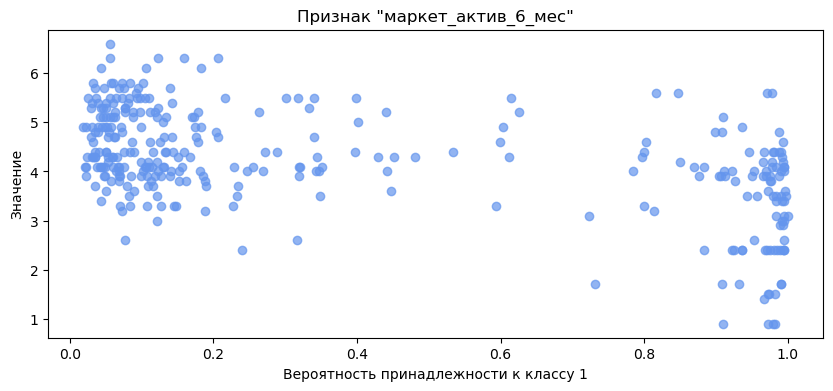

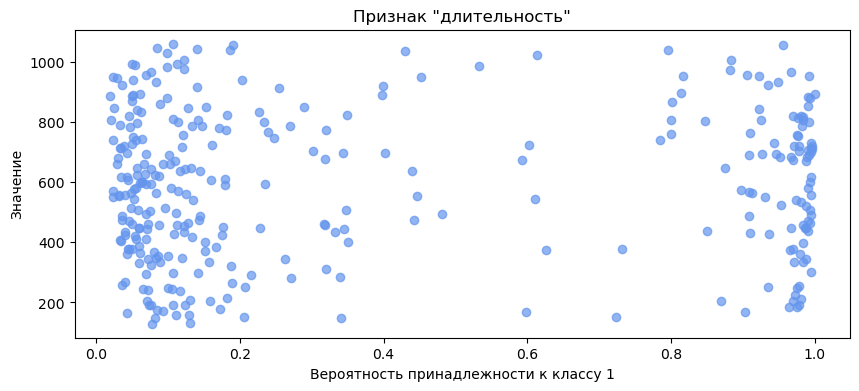

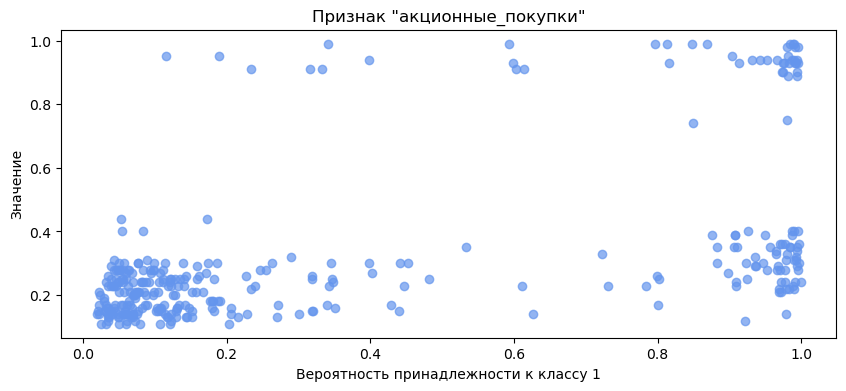

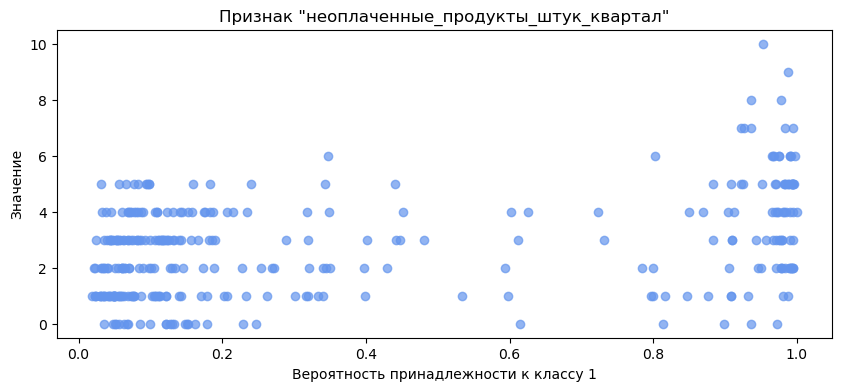

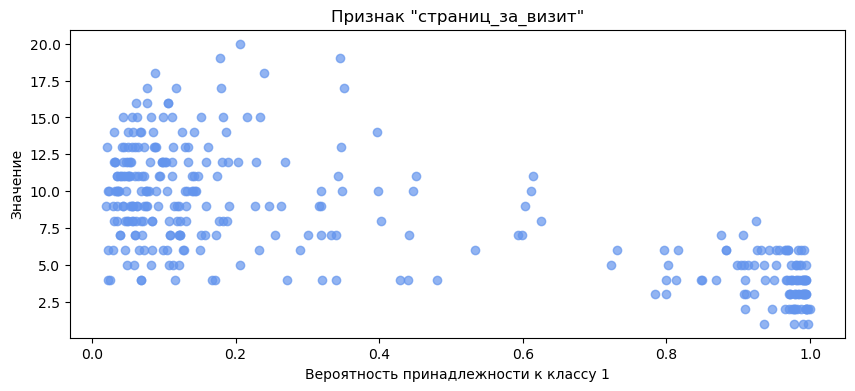

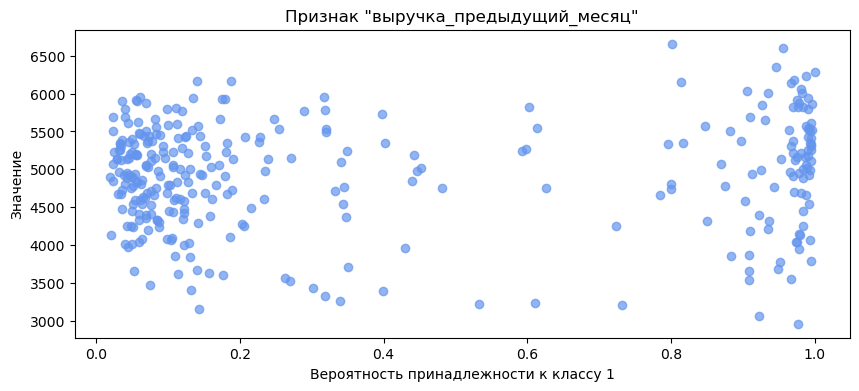

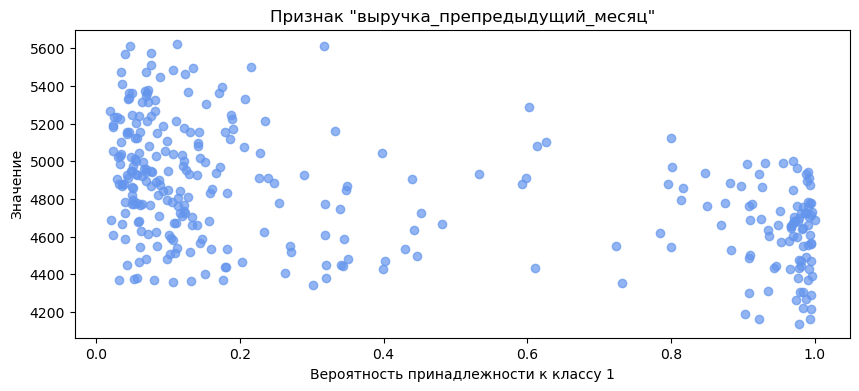

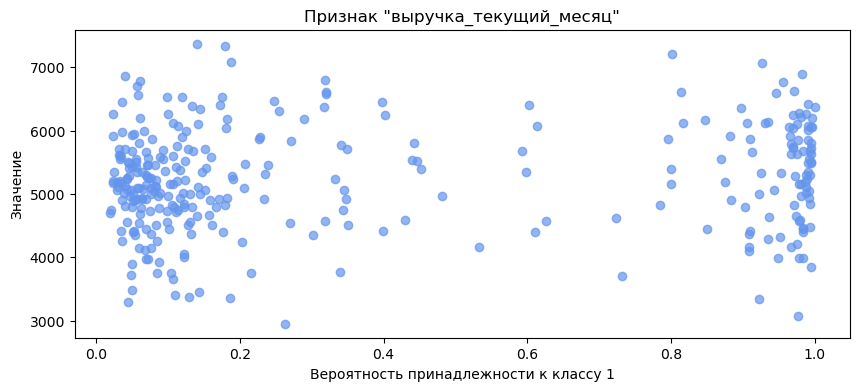

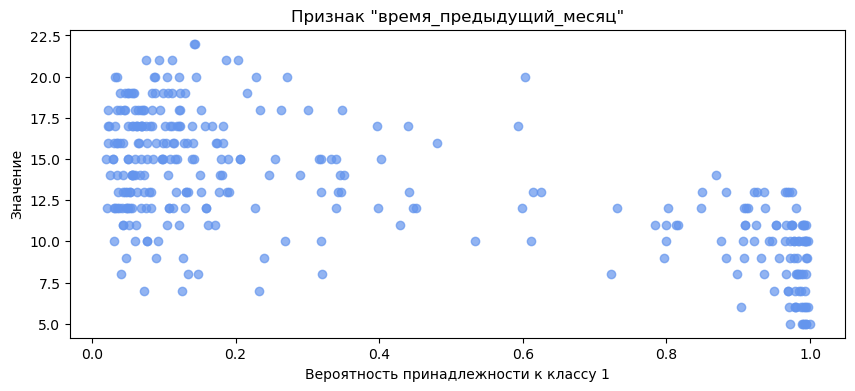

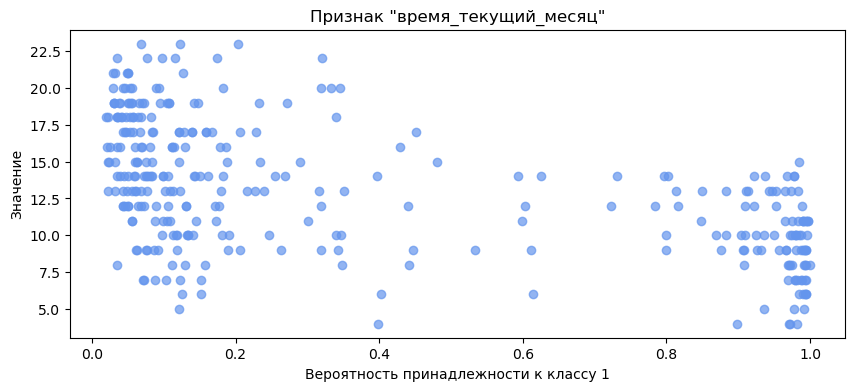

In [52]:
for name in num_columns:
    plt.figure(figsize=(10, 4))
    plt.title(f'Признак "{name}"')
    plt.xlabel('Вероятность принадлежности к классу 1')
    plt.ylabel('Значение')
    plt.scatter(x=df_proba['вероятность'], 
                y=df_proba[name],
                alpha=0.7, 
                c='cornflowerblue')

На основании приведенных графиков можно выделить следующие пороговые значения признаков для разделения покупателей на классы. В частности, покупатели со сниженной активностью имеют значения признаков:

- `Маркет_актив_6_мес` на уровне 2-4, что ниже, чем у группы с прежней активностью.
- `Длительность`: на графике видно, что скопление точек в районе отметки 0 (группа с прежней активностью) более многочисленное, но и сама эта группа более многочисленная. Значение признака для группы не различается или различается незначительно.
- `Акционные_покупки`: количество покупок товаров по акции у целевой группы выше, чем у группы покупателей с прежней активностью.
- `Неоплаченные_продукты_штук_квартал`: большее количество неоплаченных товаров в корзине у целевой группы (с пониженной покупательской активностью).
- `Страниц_за_визит`: группа покупателей со сниженной покупательской активностью просматривает меньше страниц за визит (до 10 против 20 для другой группы).
- `Выручка_предыдущий_месяц` и `Выручка_текущий_месяц`: заметных различий в поведении групп на графике не видно.
- `Выручка_препредыдущий_месяц`: у целевой группы выручка за предпредыдущий месяц меньше (у группы со сниженной активностью точки скапливаются в районе отметок 4600-4800, редко выше 5000, у группы с прежним уровнем активности — большое скопление на уровне 4800-5200 и достигает 5600).
- `Время_предыдущий_месяц`, `Время_текущий_месяц`: покупатели из целевой группы проводят меньше времени в приложении за последние два месяца.


### Выберем группу покупателей и предложим, как увеличить её покупательскую активность: 
Проведем графическое и аналитическое исследование группы покупателей.
Сделаем предложения по работе с сегментом для увеличения покупательской активности.

Для сегментации покупателей отберем группу покупателей с высокой вероятностью снижения активности и высокой прибыльностью. Проведем графический и аналитический анализ этих групп, чтобы лучше понять их поведение и потребности.
На основе анализа, предложим стратегии для увеличения покупательской активности в выбранной группе. Например, если обнаружим, что группа покупателей с высокой вероятностью снижения активности и высокой прибыльностью часто покупает определенные товары, можно предложить специальные акции или скидки на эти товары, чтобы стимулировать их активность.

Создадим функцию для отнесения покупателей к категориям: 
- 1 квантиль вероятности отнесения к категории с пониженной покупательской активностью — 1 категория;
- 2 квантиль вероятности отнесения к категории с пониженной покупательской активностью — 2 категория;
- 3 квантиль вероятности отнесения к категории с пониженной покупательской активностью — 3 категория;
- 4 квантиль вероятности отнесения к категории с пониженной покупательской активностью — 4 категория.


- 1 квантиль выручки за 3 месяца — 1 категория;
- 2 квантиль выручки за 3 месяца — 2 категория;
- 3 квантиль выручки за 3 месяца — 3 категория;
- 4 квантиль выручки за 3 месяца — 4 категория.

Функция возвращает округленное до ближайшего целого числа среднее двух значений. Таким образом, к 4 категории покупателей относятся клиенты с высокой доходностью и высокой вероятностью снижения покупательской активности. 

In [53]:
def get_category(row):
    prob = row['вероятность']
    revenue_month = row['выручка_текущий_месяц']
    revenue_prev_month = row['выручка_предыдущий_месяц']
    revenue_preprev_month = row['выручка_препредыдущий_месяц']

    # Суммируем выручку за два месяца
    total_revenue = revenue_month + revenue_prev_month + revenue_preprev_month

    # Определяем категорию на основе вероятности
    if prob <= df_proba['вероятность'].quantile(0.25):
        prob_category = 1
    elif prob <= df_proba['вероятность'].quantile(0.5):
        prob_category = 2
    elif prob <= df_proba['вероятность'].quantile(0.75):
        prob_category = 3
    else:
        prob_category = 4

    # Определяем категорию на основе прибыли
    if total_revenue <= df_proba[[
        'выручка_текущий_месяц', 
        'выручка_предыдущий_месяц', 
        'выручка_препредыдущий_месяц'
    ]].sum(axis=1).quantile(0.25):
        revenue_category = 1
    elif total_revenue <= df_proba[[
        'выручка_текущий_месяц', 
        'выручка_предыдущий_месяц', 
        'выручка_препредыдущий_месяц'
    ]].sum(axis=1).quantile(0.5):
        revenue_category = 2
    elif total_revenue <= df_proba[[
        'выручка_текущий_месяц', 
        'выручка_предыдущий_месяц', 
        'выручка_препредыдущий_месяц'
    ]].sum(axis=1).quantile(0.75):
        revenue_category = 3
    else:
        revenue_category = 4

    # Верните среднюю категорию из двух, округленную до ближайшего целого числа
    return round((prob_category + revenue_category) / 2)

# Примените функцию к каждой строке DataFrame
df_proba['категория'] = df_proba.apply(get_category, axis=1)

In [54]:
df_proba[['категория', 'выручка_текущий_месяц', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'вероятность']].sample(10)

,категория,выручка_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,вероятность
id,,,,,
215939,2,4146.6,4709.5,5509.0,0.076552
215862,2,5553.6,5330.0,5222.0,0.032689
216366,2,5053.4,4666.0,4369.0,0.079519
216370,3,6531.4,5767.0,5035.0,0.118845
216532,2,5063.0,4686.0,4401.0,0.151081
215625,4,5674.8,5348.5,4777.0,0.993862
215752,3,5798.2,5188.5,4635.0,0.441967
216555,3,6533.4,5801.5,5107.0,0.097646
216243,2,3660.6,4438.0,5485.0,0.106925


**Построим круговые диаграммы для категориальных признаков для 4 группы покупателей**

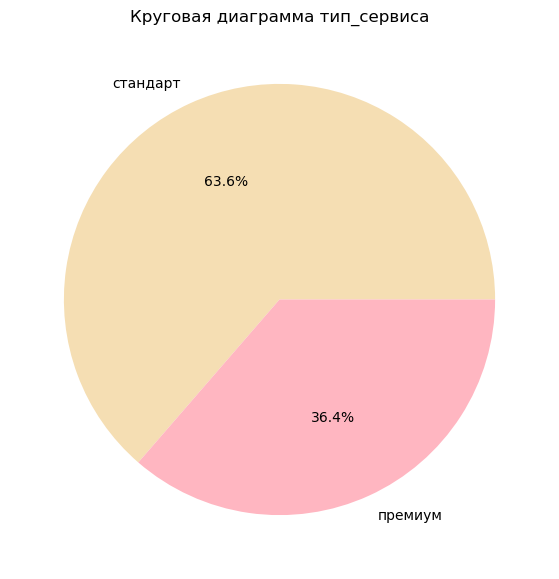

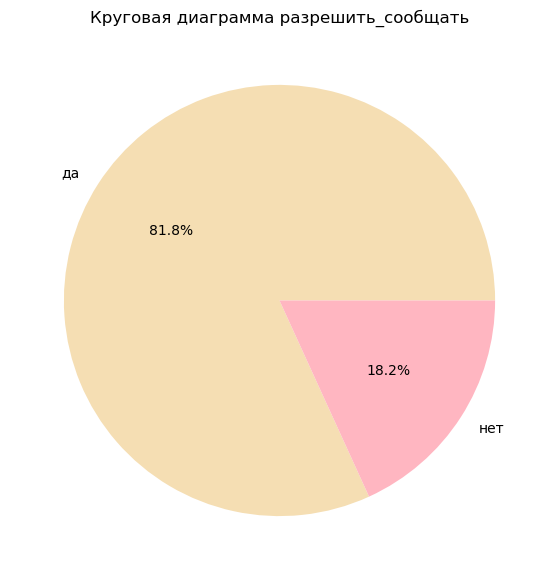

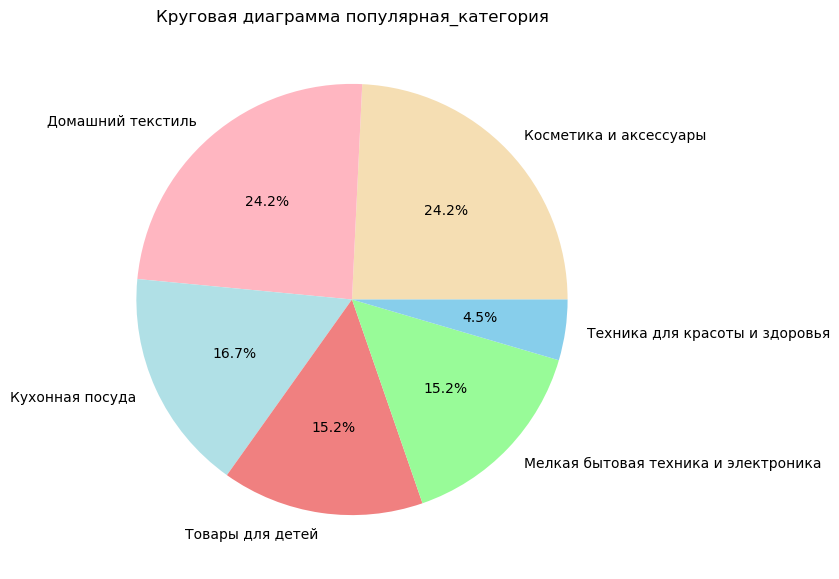

In [55]:
group_4 = df_proba[df_proba['категория'] == 4]

cat_features = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']

# круговые диаграммы для каждого категориального признака
for feature in cat_features:
    plot_pie(group_4, feature)

**Тип сервиса**

61% пользователей выбранной для проведения дополнительного исследования группы пользуются сервисом без подписки, 39% имеют подписку "премиум". Для сравнения, среди *всех* клиентов сервиса 29 % имеют подписку "премиум".

**Разрешить сообщать**

У 86% пользователей группы включены уведомления от приложения. 

**Популярными категориями являются:**

- домашний текстиль
- косметика и аксессуары
- кухонная посуда
- мелкая бытовая техника и электроника
- товары для детей
- техника для красоты и здоровья

**Посмотрим отличия покупательского поведения на гистограммах для числовых признаков для клиентов группы со сниженной покупательской активностью и с актиностью на прежнем уровне**

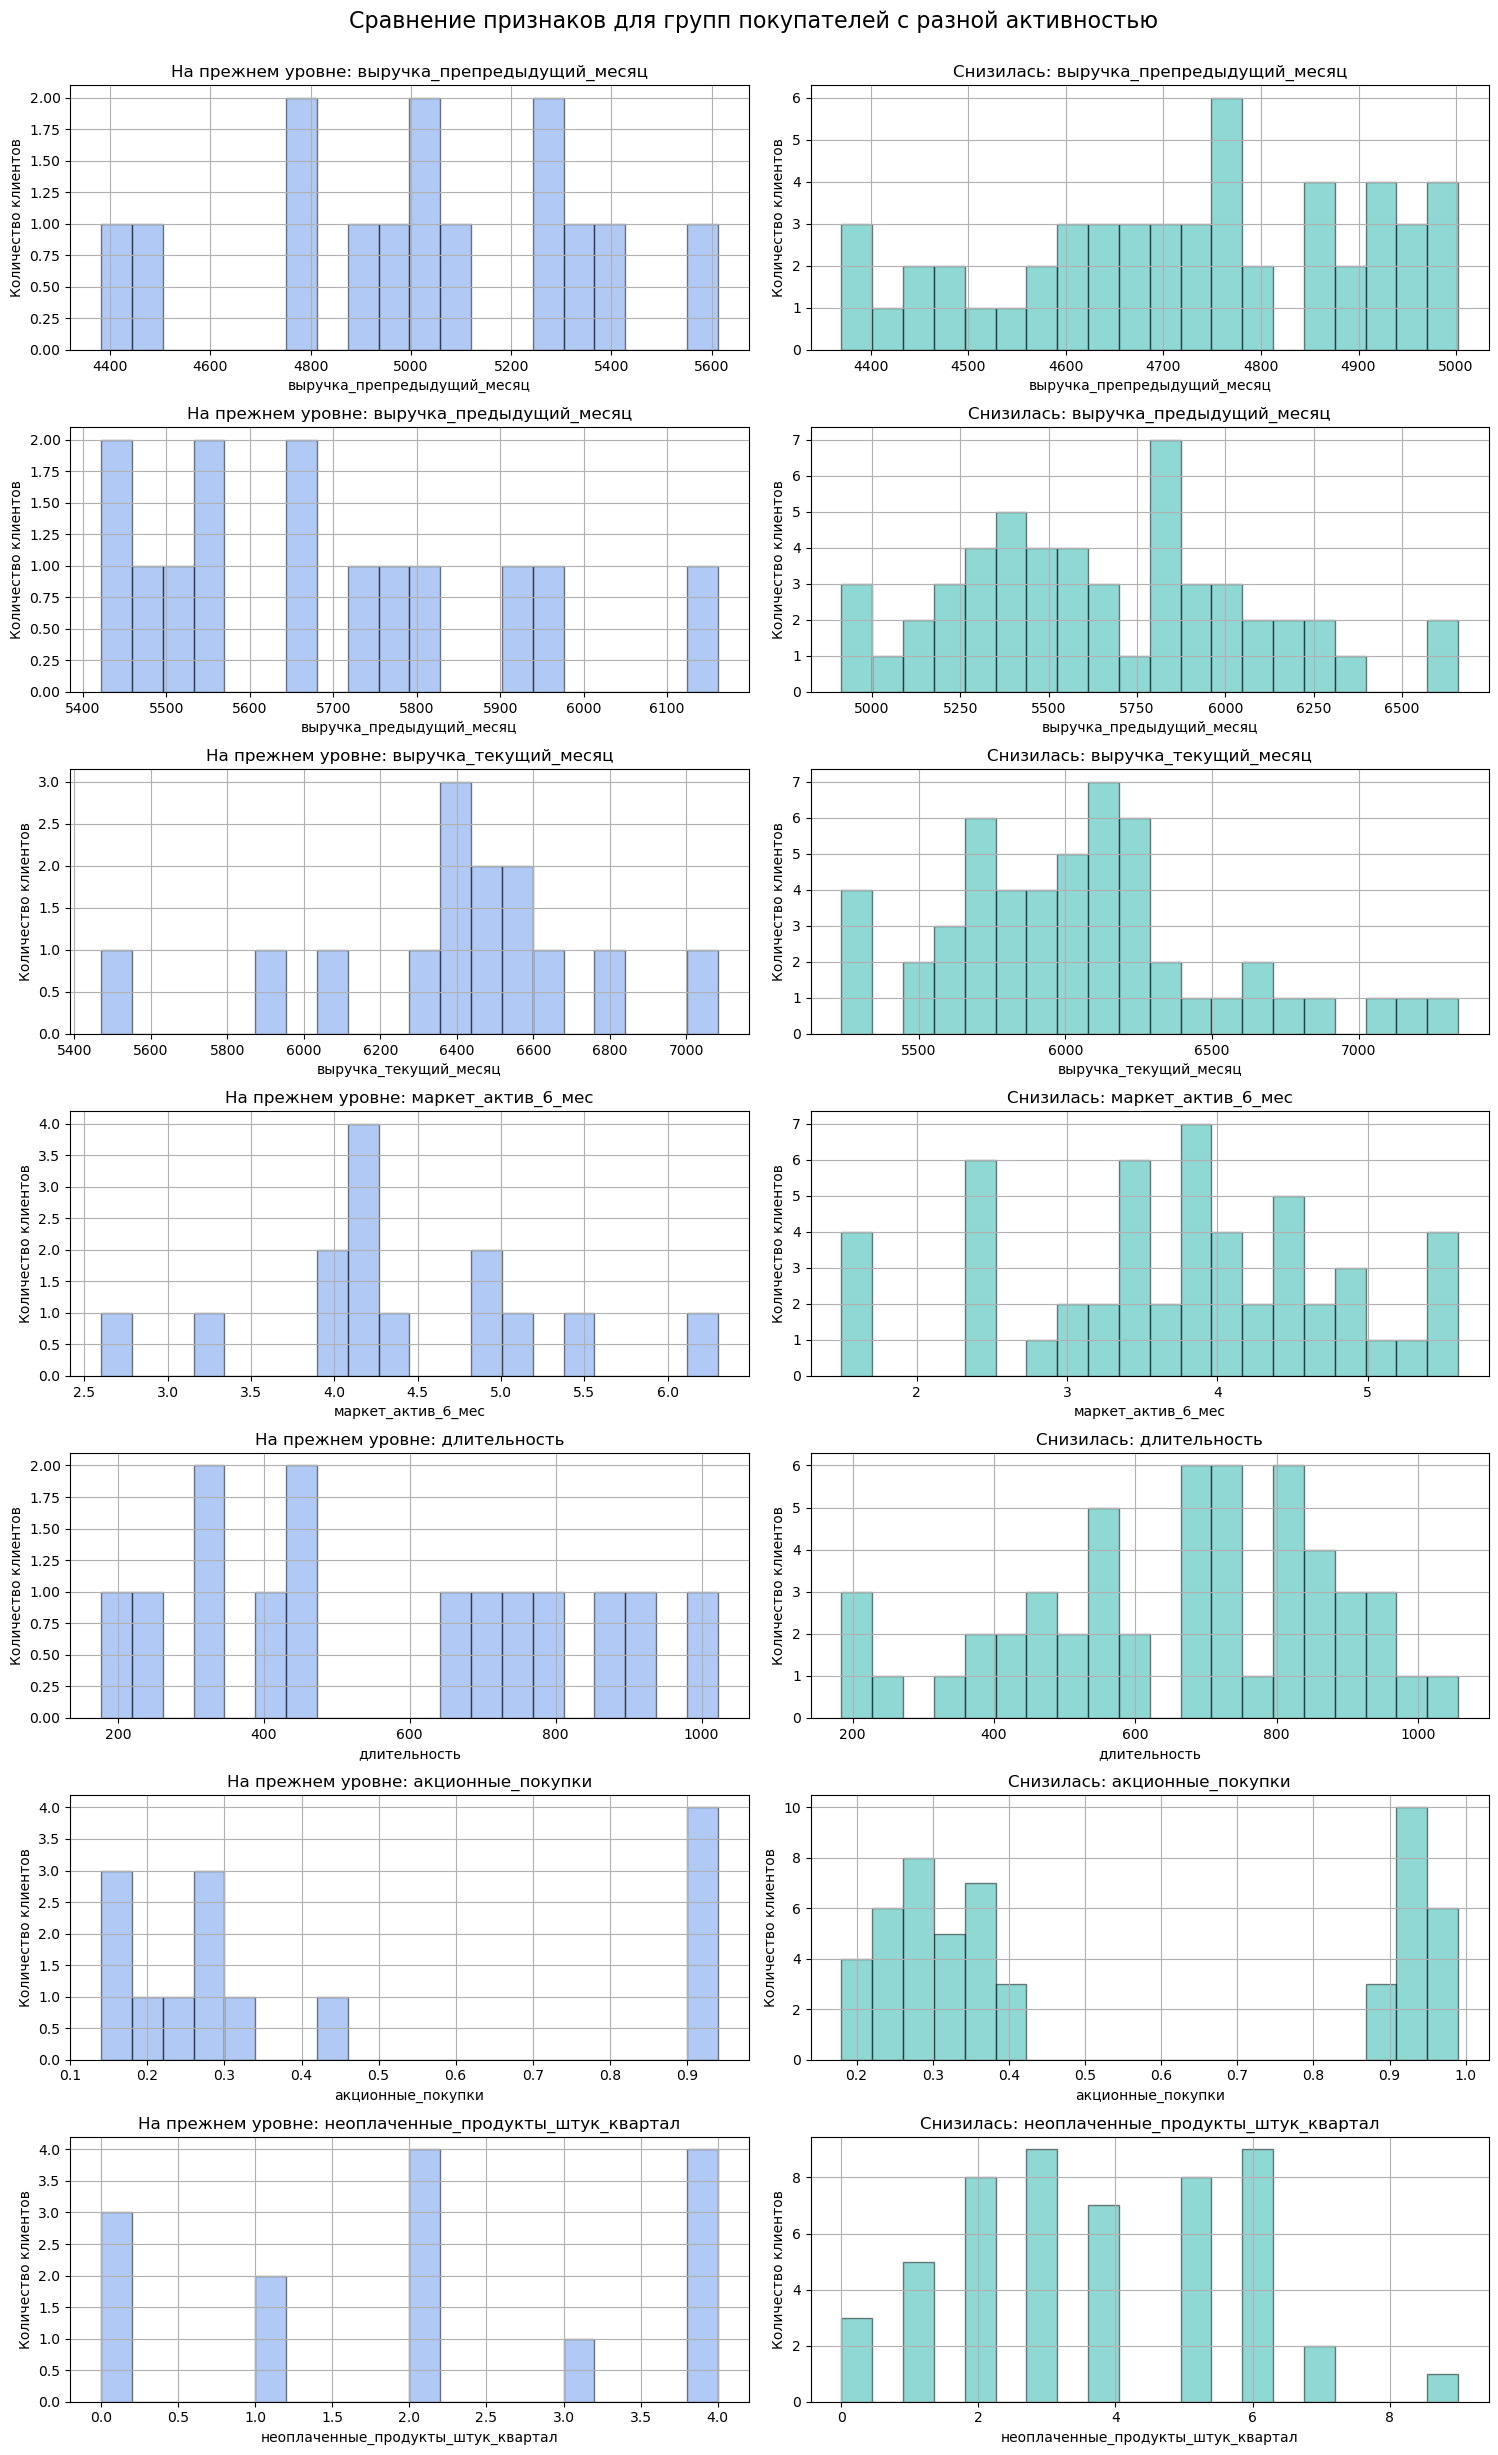

In [56]:
df_proba = df_proba.assign(покупательская_активность = df['покупательская_активность'])
# Список признаков для сравнения
features = [
    'выручка_препредыдущий_месяц',
    'выручка_предыдущий_месяц', 
    'выручка_текущий_месяц',
    'маркет_актив_6_мес', 
    'длительность', 
    'акционные_покупки', 
    'неоплаченные_продукты_штук_квартал'
]
group_4 = df_proba[df_proba['категория'] == 4]
features = [
    'выручка_препредыдущий_месяц',
    'выручка_предыдущий_месяц', 
    'выручка_текущий_месяц',
    'маркет_актив_6_мес', 
    'длительность', 
    'акционные_покупки',
    'неоплаченные_продукты_штук_квартал'
]

# Построим гистограммы для каждого признака
fig, axs = plt.subplots(len(features), 2, figsize=(15, 25))

# Добавим общий заголовок
fig.suptitle('Сравнение признаков для групп покупателей с разной активностью', fontsize=16)

for i, feature in enumerate(features):
    # Гистограмма для группы 0
    ax = axs[i, 0]
    group_4[(group_4['покупательская_активность'] == 0) & (group_4[feature].notna())][feature].hist(
        alpha=0.5, bins=20, color='cornflowerblue', edgecolor='black', ax=ax
    )
    ax.set_title(f'На прежнем уровне: {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Количество клиентов')

    # Гистограмма для группы 1
    ax = axs[i, 1]
    group_4[(group_4['покупательская_активность'] == 1) & (group_4[feature].notna())][feature].hist(
        alpha=0.5, bins=20, color='lightseagreen', edgecolor='black', ax=ax
    )
    ax.set_title(f'Снизилась: {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Количество клиентов')

plt.tight_layout()
# Добавим пространство для общего заголовка
plt.subplots_adjust(top=0.95)
plt.show()

- выручка за препредыдущий месяц у покупателей с низкой активностью ниже, чем у другой группы
- выручка за предыдущий месяц у покупателей с пониженной активностью выше, чем у другой группы
- выручка за текущий месяц у покупателей с пониженной активностью ниже, чем у другой группы
- маркет актив 6 месяцев не имеет видимых отличий на гистограмме
- длительность не имеет значительных отличий
- покупатели с низкой активностью чаще покупают товары по акции
- у клиентов с низкой активностью больше неоплаченных товаров в корзине

### Сделаем выводы о сегменте:


Для сегментации покупателей была выбрана группу покупателей с высокой вероятностью снижения активности и высокой прибыльностью. На основании приведенных графиков можно выделить следующие пороговые значения признаков для разделения покупателей на классы. В частности, покупатели со сниженной активностью имеют значения признаков:

- `Маркет_актив_6_мес` на уровне 2-4, что ниже, чем у группы с прежней активностью.
- `Маркет_актив_тек_мес`: дискретный признак, отличия на графике не видны.
- `Длительность`: на графике видно, что скопление точек в районе отметки 0 (группа с прежней активностью) более многочисленное, но и сама эта группа более многочисленная. Значение признака для группы не различается или различается незначительно.
- `Акционные_покупки`: количество покупок товаров по акции у целевой группы выше, чем у группы покупателей с прежней активностью.
- `Средний_просмотр_категорий_за_визит`: дискретный признак, различия на графике не видны.
- `Неоплаченные_продукты_штук_квартал`: большее количество неоплаченных товаров в корзине у целевой группы (с пониженной покупательской активностью).
- `Ошибка_сервиса`: дискретный признак, различия на графике не видны или незначительны.
- `Страниц_за_визит`: группа покупателей со сниженной покупательской активностью просматривает меньше страниц за визит (до 10 против 20 для другой группы).
- `Выручка_предыдущий_месяц` и `Выручка_текущий_месяц`: заметных различий в поведении групп на графике не видно.
- `Выручка_препредыдущий_месяц`: у целевой группы выручка за предпредыдущий месяц меньше (у группы со сниженной активностью точки скапливаются в районе отметок 4600-4800, редко выше 5000, у группы с прежним уровнем активности — большое скопление на уровне 4800-5200 и достигает 5600).
- `Время_предыдущий_месяц`, `Время_текущий_месяц`: покупатели из целевой группы проводят меньше времени в приложении за последние два месяца.
Для сегментации покупателей отберем группу покупателей с высокой вероятностью снижения активности и высокой прибыльностью. Проведем графический и аналитический анализ этих групп, чтобы лучше понять их поведение и потребности.
На основе анализа, предложим стратегии для увеличения покупательской активности в выбранной группе. Например, если обнаружим, что группа покупателей с высокой вероятностью снижения активности и высокой прибыльностью часто покупает определенные товары, можно предложить специальные акции или скидки на эти товары, чтобы стимулировать их активность.

**Тип сервиса**
61% пользователей выбранной для проведения дополнительного исследования группы пользуются сервисом без подписки, 39% имеют подписку "премиум". 

**Разрешить сообщать**
У 86% пользователей группы включены уведомления от приложения. 

**Популярными категориями являются:**
- домашний текстиль
- косметика и аксессуары
- кухонная посуда
- мелкая бытовая техника и электроника
- товары для детей
- техника для красоты и здоровья

Основные различия пользователей из 4 группы с низкой и прежней активностью:
- средняя выручка за 2 месяца покупателей с пониженной активностью выше, чем у другой группы
- выручка за препредыдущий месяц у покупателей с низкой активностью снижается по сравнению с другой группой
- покупатели с низкой активностью чаще покупают товары по акции
- у клиентов с низкой активностью больше неоплаченных товаров в корзине
- маркет актив 6 месяцев не имеет видимых отличий на гистограмме
- длительность не имеет значительных отличий

Какие можно сделать предложения для увеличения активности клиентов:

1. Среди клиентов выбранной группы пользуется популярностью премиум-подписка на сервис. Можно предложить бесплатный или льготный период премиум-подписки в течение 1-3 месяцев, чтобы пользователи в это время могли пользоваться всеми преимуществами подписки. Возможно, по окончании льготного периода они захотят продлить подписку или будут покупать больше товаров.
2. Предложить скидки на популярные среди клиентов выбранной группы категории товаров (домашний текстиль, косметика и аксессуары,  кухонная посуда, мелкая бытовая техника и электроника).
3. У клиентов группы более высокое количество неоплаченных товаров в корзине. Можно предложить скидку на эти товары.

## Общий вывод

В ходе исследования был проведен анализ данных о поведении покупателей на сайте, их взаимодействии с магазином, выручке и времени, проведенном на сайте. Были выявлены ключевые признаки, влияющие на покупательскую активность, и построена модель для прогнозирования этой активности.

Основные выводы:

Активность пользователя на сайте (количество страниц за визит, время на сайте) является наиболее значимым фактором для модели. Это подчеркивает важность улучшения пользовательского опыта и увеличения вовлеченности пользователей.
Маркетинговая активность и количество акционных покупок также оказывают существенное влияние на предсказания модели. Это подтверждает необходимость продолжения и анализа маркетинговых кампаний.
Признаки, такие как тип сервиса и разрешение на уведомления, имеют низкую значимость. Это может указывать на то, что эти аспекты не являются ключевыми для покупательской активности.

Рекомендации:

Сосредоточиться на улучшении пользовательского опыта и увеличении вовлеченности пользователей может положительно сказаться на бизнес-метриках. Маркетинговые кампании должны быть продолжены и анализироваться, так как они значимо влияют на предсказания модели. Это поможет увеличить покупательскую активность и, как следствие, выручку магазина.

Для сегментации покупателей была выбрана группу покупателей с высокой вероятностью снижения активности и высокой прибыльностью. В ходе анализа были выделены ключевые признаки, влияющие на покупательскую активность:

- Активность на сайте: Покупатели со сниженной активностью просматривают меньше страниц за визит и проводят меньше времени на сайте.
- Маркетинговая активность: Покупатели со сниженной активностью имеют меньшее количество маркетинговых коммуникаций за последние 6 месяцев.
- Покупки по акции: Покупатели со сниженной активностью чаще покупают товары по акции.
- Неоплаченные товары: У покупателей со сниженной активностью обнаружено большее количество неоплаченных товаров в корзине.

На основе этих выводов, предлагается следующая стратегия для увеличения покупательской активности:

- Предложить бесплатный или льготный период премиум-подписки для покупателей, которые пользуются сервисом без подписки. Это может стимулировать их активность и увеличить количество покупок.
- Предложить скидки на популярные категории товаров. Это может привлечь внимание покупателей и увеличить их активность.
- Предложить скидку на неоплаченные товары в корзине. Это может стимулировать покупателей к завершению покупки.

Эти меры могут помочь увеличить покупательскую активность и, как следствие, увеличить выручку магазина.